# Proyecto: Estimación de la apreciación de una acción durante su primer año de cotización en bolsa

#### Actualizacion

1. Curva ROC de clasificacion multiple
2. Determinacion de mejor algoritmo de clasificacion (Algoritmo elegido para la clasificacion binaria)
3. Seleccion de mejor punto de corte para la clasificacion binaria
4. Cuadro resumen de performance de los puntos de corte
5. Automatizacion de la seleccion del mejor punto de corte
6. Retiro de variables continuas redundantes: MarketCap y employees (permanecen sus versiones discretas)
7. Retiro de variables no predictivas: DaysBetterThanSP, MarketYearTrend, Median, Mean y Stan. Dev.
8. Retiro de la variable 'Safe' (presumo que hace referencia al termino financiero "Simple Agreement for Future Equity") por no tener claridad en la definicion por parte de la fuente del dataset (Kaggle). **Esta era la variable mas relevante hasta el Desafio 12.**
9. Realizacion del Cross Validation para regresion y clasificacion.
10. Principal Component Analysis (PCA)


# Storytelling: Inversión en Empresas que recién salen a Cotizar

Conforme pasan los años, conseguir retornos en inversiones en acciones que superen los rendimientos de sus competidores directos se hace más difícil. La teoría financiera indica que, acciones públicas que tengan una volatilidad parecida, variarán su precio de manera similar. Conseguir un retorno adicional entre productos financieros comparables es lo que se conoce como 'alpha'. En el contexto actual, conseguir este excedente es complejo debido a que compiten por él ejércitos de analistas que potencian sus habilidades mediante el uso de cada vez más rápidos e inteligentes algoritmos predictivos.

El interés predictivo y, por consiguiente, la mayor racionalidad de mercado, se concentra alrededor de los principales índices y compañías. Es alrededor de índices como el S&P por ejemplo, que conseguir un alpha superior al 0.5% es prácticamente imposible. Sin embargo, esto deja abierta la puerta de mercados menos conocidos donde haya menos competencia por parte de grandes entidades comercializadoras de acciones y por ende, precios menos racionales. Uno de ellos, y el que investigaremos en este documento, es el mercado de las empresas que recién salieron a cotizar tras una IPO.

El objetivo principal estará en determinar qué características de una empresa apenas finalizada su IPO son más importantes para predecir su desempeño en el mercado de valores. Esta investigación contempla más de 2000 empresas que salieron a cotizar entre 1996 y 2018, y cuyos rendimientos se analizan sobre su primer año de cotización.

El impacto de esta investigación está dirigido a personas con acceso a vehículos de inversión complejos, pero que no cuentan con el capital suficiente o los contactos para acceder a IPO's y fondos sofisticados de manejo de capitales. En otras palabras, personas que han generado una buena bolsa de ahorros, pero no la suficiente para ser considerados influyentes en el mercado.

# Tabla de Contenido

#### 1. Market Trend vs Fluctuacion del Precio
1.1. ¿Qué sectores lo hacen mejor en los años alcistas?

1.2. ¿Qué sectores lo hacen mejor en los años bajistas?

1.3. ¿Cuál es la proporción de empresas que salen a cotizar en años bajistas vs alcistas?

1.4. Las empresas de los diferentes sectores se distribuirán de forma normal en cuanto a crecimiento de la valorización se refiere.


#### 2.Ubicacion Geografica
2.1 ¿Las empresas de cuáles países se desempeñan mejor por sector? Incluir un estudio de EEUU vs Resto del mundo

#### 3. Empleados
3.1 ¿La cantidad de empleados se relaciona con el Market Cap? Diferenciar por sector

#### 4. Longevidad de la Empresa
4.1 Una empresa antigua tenderá a hacerlo mejor en su primer año de cotización en mercados públicos?  Diferenciar por sector

#### 5. Volatilidad
5.1 ¿Cómo se distribuye la capitalización de mercado de las IPO's? 

5.2 ¿La capitalización de mercado está inversamente relacionada con la variación de la cotización anual y la volatilidad diaria? Diferenciar por sector

5.3 ¿Mayor volatilidad tiende a tener mayores retornos? Diferenciar por sector

5.4 ¿Hay relación entre el volumen diario medio como porcentaje del Market Cap de una acción y su volatilidad diaria?

#### 6. Ratios financieros: P/E to growth
6.1 ¿Cuál es la relación entre el P/E del año anterior a cotizar con la cotización en el primer año en bolsa? Diferenciar por sector

# Conformación del equipo de trabajo

Franco Carlini

Tutor: Álvaro Galindo

# Fuente del dataset:

Datos de compañías: https://www.kaggle.com/code/gauravnpatwardhan/ipo-data-analysis

# Primer Data Wrangling

In [2004]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import random
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
import matplotlib.ticker as mtick

In [2005]:
pd.set_option('display.max_columns', None)

In [2006]:
df = pd.read_csv("IPODataFull.csv", low_memory=False,encoding='unicode_escape')
print(df.shape)

(3762, 1664)


In [2007]:
colnames = list(df.columns)

### Separamos el DF principal en dos partes:
#### - 'main': variables no referentes a precios
#### - 'prices': variables referentes precios

In [2008]:
close_day_0 = df.columns.get_loc('closeDay0')
name = df.columns.get_loc('Name')

print(close_day_0)

df_prices = df.iloc[:,close_day_0:name]

colname_symbol = (df.columns[df.columns.get_loc('Symbol')])

df_prices.insert(0, colname_symbol, df['Symbol'])
df_prices['HomeRunDay'] = df['HomeRunDay']
df_prices['HomeRun']=df['HomeRun']
#df_prices

9


In [2009]:
df_main = df.drop(df.columns[close_day_0:name], axis=1)
df_main = df_main.drop(df.columns[-2:], axis=1)

In [2010]:
print(df_prices.shape)
print(df_main.shape)

(3762, 1313)
(3762, 352)


### 5.1. Seleccion de Variables del "df_main"

In [2011]:
df_main_columns = df_main.columns

In [2012]:
main_variables = []
for col_name in df_main.columns: 
    main_variables.append(col_name)

In [2013]:
df_main_nrows = df_main.shape[0]
df_main_nrows

3762

In [2014]:
# Identificamos las variables con pocos datos
na_s = df_main[main_variables].isna().sum()

short_columns = []
for i in range(0, len(na_s)):
    if na_s[i] > (df_main_nrows - 2000):
        short_columns.append(na_s.index[i])
        
#print(short_columns)
print(len(short_columns))

303


In [2015]:
msno.matrix(df_main)

<AxesSubplot: >

In [2016]:
# Retiramos las variables con menos de 2000 datos, son 303 de 352
df_main_clean = df_main.drop(short_columns, axis=1)
df_main_clean.shape

(3762, 49)

In [2017]:
# Visualizamos las variables restantes y elegimos las que mejor podrian explicar el valor de una IPO
df_main_clean.columns
selected_variables = ['Symbol','Name','DaysBetterThanSP', 'daysProfit','Year','Month','Day', 'dayOfWeek', 'LastSale', 'MarketCap', 'Sector'
        , 'Summary Quote','CEOTakeOver', 'CEOAge','CEOGender', 'CEOInChargeDuringIPO', 'FiscalDateEnd', 'stateCountry','City', 'Industry',
       'Revenue', 'netIncome', 'employees', 'YearFounded','Market6MonthTrend', 'MarketYearTrend', 'employeesGrouped',
       'USACompany', 'FiscalMonth','Profitable', 'Safe']

In [2018]:
df_main_clean = df_main_clean[selected_variables]

In [2019]:
df_main_clean['MarketYearTrend'] = round(df_main_clean['MarketYearTrend']/100, 4)

In [2020]:
df_main_clean.describe()

DaysBetterThanSP   daysProfit         Year        Month          Day  \
count       3762.000000  3762.000000  3762.000000  3762.000000  3762.000000   
mean         103.753057   138.153642  2008.578416     6.670122    16.756512   
std           34.461156   100.677813     6.532543     3.323697     8.906214   
min            0.000000     0.000000  1996.000000     1.000000     1.000000   
25%           96.000000    32.000000  2004.000000     4.000000     9.000000   
50%          116.000000   143.000000  2010.000000     7.000000    17.000000   
75%          126.000000   247.000000  2014.000000    10.000000    25.000000   
max          170.000000   262.000000  2018.000000    12.000000    31.000000   

         dayOfWeek     LastSale     MarketCap  CEOTakeOver       CEOAge  \
count  3762.000000  3761.000000  3.762000e+03  2740.000000  3008.000000   
mean      2.416268    31.620963  4.683294e+09  2012.890876    54.812500   
std       1.289118    53.249809  2.656513e+10     5.047217     7.738885   
min       0.000000     0.047100  0.000000e+00  1965.000000    24.000000   
25%       1.000000     8.630000  1.138619e+08  2011.000000    50.000000   
50%       3.000000    17.820000  5.136026e+08  2014.000000    55.000000   
75%       3.000000    36.500000  2.154609e+09  2016.000000    60.000000   
max       4.000000  1441.500000  7.270000e+11  2018.000000    84.000000   

       YearFounded  Market6MonthTrend  MarketYearTrend   Profitable  \
count  3010.000000        3762.000000      3762.000000  3762.000000   
mean   1994.130897           0.773722         0.009848     0.527645   
std      45.008210           1.160393         0.011168     0.499302   
min      12.000000          -4.886874        -0.041000     0.000000   
25%    1993.000000           0.103955         0.005500     0.000000   
50%    2002.000000           1.013046         0.012700     1.000000   
75%    2010.000000           1.654077         0.017400     1.000000   
max    2018.000000           2.800898         0.031000     1.000000   

              Safe  
count  3762.000000  
mean      0.173844  
std       0.379025  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

### 5.2. Encontramos caracteristicas del DF 'prices'
#### 5.2.1. Reemplazamos los nan

In [2021]:
df_prices.tail()

Symbol  closeDay0  highDay0  openDay0  lowDay0  volumeDay0  closeDay1  \
3757   ZUMZ     12.435    12.575     10.25   10.275   6793424.0     12.255   
3758    ZUO     20.000    21.850     19.12   20.000  13102419.0     20.600   
3759     ZX      5.850     6.200      5.60    6.000   4987284.0      6.250   
3760   ZYME     13.000    14.250     13.00   13.500    953887.0     13.070   
3761   ZYNE     16.250    22.250     15.50   18.000   1535500.0     19.320   

      highDay1  openDay1  lowDay1  volumeDay1  closeDay2  highDay2  openDay2  \
3757    12.845     11.70    12.55    805032.0      12.05    12.300     11.88   
3758    20.820     19.60    19.80   1864667.0      20.60    20.880     19.90   
3759     6.400      5.99     6.00   6707576.0       6.30     6.640      6.02   
3760    13.200     13.00    13.20     97009.0      13.10    13.192     13.00   
3761    19.500     16.46    16.48    331792.0      24.54    24.900     19.31   

      lowDay2  volumeDay2  closeDay3  highDay3  openDay3  lowDay3  volumeDay3  \
3757    12.25    358766.0     12.125   12.3000    11.925    12.10    282498.0   
3758    20.88    907867.0     19.550   20.6600    19.000    20.55   1152504.0   
3759     6.05    515136.0      6.040    6.2500     6.040     6.25    321123.0   
3760    13.00     68578.0     13.280   13.3952    13.100    13.10     40809.0   
3761    19.31    269397.0     35.140   42.8500    27.500    29.70    539255.0   

      closeDay4  highDay4  openDay4  lowDay4  volumeDay4  closeDay5  highDay5  \
3757      11.75   12.0000   11.7500    11.83    252255.0      11.56    11.969   
3758      19.56   20.4200   19.0742    19.61    886009.0      19.65    19.720   
3759       6.08    6.1500    6.0800     6.12    162260.0       6.05     6.140   
3760      13.11   13.5000   13.0000    13.34     33256.0      13.05    13.200   
3761      29.73   37.6882   28.1600    35.98    243632.0      32.05    36.000   

      openDay5  lowDay5  volumeDay5  closeDay6  highDay6  openDay6  lowDay6  \
3757    11.550    11.71    154172.0    11.5810     11.60    11.375   11.555   
3758    19.211    19.57    463459.0    19.7200     19.73    19.450   19.550   
3759     6.000     6.14    787028.0     6.0095      6.10     5.990    6.100   
3760    13.000    13.16     20538.0    13.0300     13.13    13.000   13.130   
3761    28.000    28.91    238014.0    36.4900     43.00    32.520   35.000   

      volumeDay6  closeDay7  highDay7  openDay7  lowDay7  volumeDay7  \
3757    102162.0     12.415   12.4150   11.3800    11.38     80208.0   
3758    300461.0        NaN       NaN       NaN      NaN         NaN   
3759    174288.0      6.030    6.0900    5.8500     5.85     95852.0   
3760     11444.0     13.000   13.0500   13.0000    13.00     72822.0   
3761    407807.0     34.840   39.4999   33.6797    37.98    233090.0   

      closeDay8  highDay8  openDay8  lowDay8  volumeDay8  closeDay9  highDay9  \
3757      12.56     12.95     12.18    12.42    341784.0      12.85     12.97   
3758        NaN       NaN       NaN      NaN         NaN        NaN       NaN   
3759       6.00      6.10      6.00     6.10    113431.0       6.01      6.10   
3760      13.09     13.09     13.00    13.03     13474.0      13.09     13.10   
3761      34.11     36.30     32.04    35.42    124093.0      32.22     34.72   

      openDay9  lowDay9  volumeDay9  closeDay10  highDay10  openDay10  \
3757     12.50    12.97     93574.0       12.75     13.225     12.565   
3758       NaN      NaN         NaN         NaN        NaN        NaN   
3759      6.00     6.10    134606.0        6.01      6.010      5.880   
3760     13.05    13.10     19341.0       13.00     13.120     13.000   
3761     31.45    34.72    141591.0       31.28     31.690     29.380   

      lowDay10  volumeDay10  closeDay11  highDay11  openDay11  lowDay11  \
3757     13.00     230708.0      12.895     13.190     12.655     13.19   
3758       NaN          NaN         NaN        NaN        NaN       NaN   
3759      5.88     296

In [2022]:
# Para reemplazar los nan con valores de dias anteriores es necesario que sean de la misma medicion
df_closeDay_prices = df_prices.loc[:, df_prices.columns.str.contains('closeDay')]
df_highDay_prices = df_prices.loc[:, df_prices.columns.str.contains('highDay')]
df_openDay_prices = df_prices.loc[:, df_prices.columns.str.contains('openDay')]
df_lowDay_prices = df_prices.loc[:, df_prices.columns.str.contains('lowDay')]
df_volumeDay_prices = df_prices.loc[:, df_prices.columns.str.contains('volumeDay')]

In [2023]:
# Convertimos los DF en Arrays para reemplazar mas facilmente el 'nan' por el valor anterior

array_close_prices = df_closeDay_prices.to_numpy()
array_high_prices = df_highDay_prices.to_numpy()
array_open_prices = df_openDay_prices.to_numpy()
array_low_prices = df_lowDay_prices.to_numpy()
array_volume_prices = df_volumeDay_prices.to_numpy()

In [2024]:
def nan_replacer(num_array):
    nan_location_array = np.where(np.isnan(num_array))
    counter_row = -1
    for i in num_array:
        if counter_row < len(num_array):
            counter_row += 1
            if counter_row in nan_location_array[0]:
                counter_col = -1

                for j in i:
                    counter_col += 1
                    if np.isnan(j):
                        num_array[counter_row, counter_col] = num_array[counter_row, counter_col-1]

In [2025]:
nan_replacer(array_close_prices)
nan_replacer(array_low_prices)
nan_replacer(array_open_prices)
nan_replacer(array_low_prices)
nan_replacer(array_volume_prices)

#### Insertamos la Media, Mediana y Desviacion Estandar en los DF

In [2026]:
# Convertimos los arrays sin nan's en DF para efectuar los calculos

df_closeDay_prices_clean = pd.DataFrame(array_close_prices, columns=df_closeDay_prices.columns)
df_highDay_prices_clean = pd.DataFrame(array_high_prices, columns=df_highDay_prices.columns)
df_openDay_prices_clean = pd.DataFrame(array_open_prices, columns=df_openDay_prices.columns)
df_lowDay_prices_clean = pd.DataFrame(array_low_prices, columns=df_lowDay_prices.columns)
df_volumeDay_prices_clean = pd.DataFrame(array_volume_prices, columns=df_volumeDay_prices.columns)

In [2027]:
def statistical_characteristics(df_day_prices_clean):
    df_day_prices_clean["Mean"] = df_day_prices_clean.mean(axis = 1)
    df_day_prices_clean["Median"] = df_day_prices_clean.median(axis = 1)
    df_day_prices_clean["Stan Dev."] = df_day_prices_clean.std(axis = 1)
    df_day_prices_clean["Symbol"] = df_main_clean["Symbol"]
    first_column = df_day_prices_clean.pop('Symbol')
    df_day_prices_clean.insert(0, 'Symbol', first_column)

In [2028]:
statistical_characteristics(df_closeDay_prices_clean)
statistical_characteristics(df_highDay_prices_clean)
statistical_characteristics(df_openDay_prices_clean)
statistical_characteristics(df_lowDay_prices_clean)
statistical_characteristics(df_volumeDay_prices_clean)

# Exploratory Data Analysis (EDA): Univariado y Bivariado

## 1. Market Trend vs Fluctuacion del Precio
### 1.1. ¿Qué sectores lo hacen mejor en los años alcistas?

Diferentes sectores en la economía se comportan de distintas formas en cada una de las partes del ciclo económico. Al ser empresas que recién salen a cotizar, debemos verificar si hace sentido invertir de forma diferenciada en cuanto al ciclo económico. Podría darse el caso que al ser empresas nuevas en el mercado de valores, no respondan al ciclo económico como empresas que llevan cotizando varios años.

In [2029]:
df_MarketYearTrend = df_main_clean[['Symbol','Sector','netIncome', 'MarketCap', 'MarketYearTrend']]
df_MarketYearTrend.drop_duplicates(subset='Symbol', inplace=True)
df_MarketYearTrend2 = pd.merge(df_MarketYearTrend, df_closeDay_prices_clean, on=['Symbol'], how='inner')
df_MarketYearTrend2.drop(df_MarketYearTrend2.iloc[:,5:-4], axis=1, inplace=True)
df_MarketYearTrend2 = df_MarketYearTrend2.drop_duplicates(subset='Symbol')
df_MarketYearTrend2.shape

(3699, 9)

In [2030]:
# Feature Engineering (Year_Price_Variation)
df_closeDay_prices_clean["Year_Price_Variation"] = (df_closeDay_prices_clean['closeDay261'] - df_closeDay_prices_clean['closeDay0'])/df_closeDay_prices_clean['closeDay0']

df = df_main_clean[['Symbol','Sector','netIncome', 'MarketCap', 'Year', 'YearFounded', 'MarketYearTrend']]
df_MarketYearTrend3 = pd.merge(df, df_closeDay_prices_clean, on=['Symbol'], how='inner')
df_MarketYearTrend3.drop(df_MarketYearTrend3.iloc[:,4:5], axis=1, inplace=True)
df_MarketYearTrend3.drop(df_MarketYearTrend3.iloc[:,6:-4], axis=1, inplace=True)
df_MarketYearTrend3 = df_MarketYearTrend3.drop_duplicates(subset='Symbol')

In [2031]:
df_MarketYearTrend3

Symbol             Sector netIncome     MarketCap  YearFounded  \
0         A      Capital Goods  $684.00M  2.198323e+10       1999.0   
1       AAC        Health Care  $-20.58M  2.707691e+08       2014.0   
2      AAOI         Technology   $73.95M  5.844368e+08       1997.0   
3       AAP  Consumer Services  $475.51M  7.874971e+09       1929.0   
4       AAT  Consumer Services   $29.08M  1.604956e+09       2010.0   
...     ...                ...       ...           ...          ...   
7789   ZUMZ  Consumer Services   $26.80M  6.085133e+08       1978.0   
7790    ZUO                NaN  $-47.16M  2.132269e+09       2007.0   
7791     ZX      Capital Goods    $1.34M  6.711250e+07       2008.0   
7792   ZYME        Health Care  $-10.41M  3.068106e+08       2003.0   
7793   ZYNE        Health Care  $-32.01M  1.358850e+08       2007.0   

      MarketYearTrend       Mean   Median  Stan Dev.  Year_Price_Variation  
0              0.0204  46.378060  44.8908  16.334874              0.114706  
1              0.0088  30.168664  29.5400   7.078500              0.320541  
2              0.0144  18.051160  18.4200   4.599134              0.687751  
3             -0.0075  16.715145  16.7000   1.840810              0.236187  
4              0.0226  20.724008  21.1500   1.295989             -0.026353  
...               ...        ...      ...        ...                   ...  
7789           0.0055  20.283076  17.8850   5.973934              1.800161  
7790           0.0079  19.726260  19.7200   0.079838             -0.014000  
7791           0.0149   4.346186   4.2800   0.842612             -0.408547  
7792           0.0174   9.561016   8.8000   1.940077             -0.078462  
7793           0.0084  12.007557   9.6700   6.526545             -0.353846  

[3699 rows x 10 columns]

In [2032]:
sns.distplot(df_MarketYearTrend3['Year_Price_Variation'])
plt.title('Distribucion de Variacion de Precio', fontsize = 20, fontweight = 20)
plt.xlabel('Variacion de Precio', fontsize = 15, fontweight = 20)
plt.ylabel('Densidad', fontsize = 15, fontweight = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

(array([0. , 0.2, 0.4, 0.6, 0.8]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8')])

In [2033]:
df_MarketYearTrend3.Sector = df_MarketYearTrend3.Sector.fillna('No Specific Sector')

df_MarketYearTrend3.head()

# Eliminar compañias con variaciones mayores al 250% (se multiplica 2.5x su cotización en bolsa el primer año).
index_year_price_change = df_MarketYearTrend3[(df_MarketYearTrend3['Year_Price_Variation'] >= 2.5)].index
df_MarketYearTrend3.drop(index_year_price_change , inplace=True)
df_MarketYearTrend3.shape

(3637, 10)

In [2034]:
df_MarketYearTrend_Alcista = df_MarketYearTrend3.loc[(df_MarketYearTrend3['MarketYearTrend'] > 0)]
df_MarketYearTrend_Alcista.shape

(2977, 10)

In [2035]:
df_MarketYearTrend_Alcista1 = df_MarketYearTrend_Alcista

fig = px.box(df_MarketYearTrend_Alcista1, y="Sector", x="Year_Price_Variation", color="Sector",
             notched=False, # used notched shape
             title="Performance during 'Bullish' years",
            )
fig.show()

In [2036]:
df_MarketYearTrend_Alcista_Tabla = df_MarketYearTrend_Alcista1.groupby('Sector').mean()['Year_Price_Variation']
df_MarketYearTrend_Alcista_Tabla = df_MarketYearTrend_Alcista_Tabla.to_frame()
df_MarketYearTrend_Alcista_Tabla.rename(columns={'Year_Price_Variation': 'Mean'}, inplace=True)
# df_MarketYearTrend_Alcista_Tabla

In [2037]:
df_MarketYearTrend_Alcista_Tabla['Median'] = df_MarketYearTrend_Alcista1.groupby('Sector').median()['Year_Price_Variation']
df_MarketYearTrend_Alcista_Tabla['Std'] = df_MarketYearTrend_Alcista1.groupby('Sector').std()['Year_Price_Variation']
df_MarketYearTrend_Alcista_Tabla['Max'] = df_MarketYearTrend_Alcista1.groupby('Sector').max()['Year_Price_Variation']
df_MarketYearTrend_Alcista_Tabla['Min'] = df_MarketYearTrend_Alcista1.groupby('Sector').min()['Year_Price_Variation']
df_MarketYearTrend_Alcista_Tabla['Count'] = df_MarketYearTrend_Alcista1.groupby('Sector').count()['Year_Price_Variation']

In [2038]:
df_MarketYearTrend_Alcista_Tabla.sort_values(by='Median', ascending=False)

Mean    Median       Std       Max       Min  Count
Sector                                                                        
Miscellaneous          0.223246  0.174103  0.657948  2.247138 -0.983711     82
Consumer Durables      0.082026  0.060606  0.574992  2.250000 -0.791667     47
Energy                 0.111900  0.046689  0.476948  1.646067 -0.805926    136
Finance                0.087107  0.027804  0.365149  2.017544 -0.912992    480
Basic Industries       0.149894  0.026455  0.689415  2.434057 -0.959219     95
Consumer Non-Durables  0.064113  0.007557  0.511624  1.678857 -0.999978     78
Consumer Services      0.055804  0.006491  0.449998  2.273304 -0.971667    434
Public Utilities       0.030419  0.005342  0.424479  1.129964 -0.876424    105
Capital Goods          0.105379  0.004794  0.599886  2.221863 -0.893283    130
Technology             0.080098 -0.011721  0.673152  2.405405 -0.984504    327
No Specific Sector    -0.019492 -0.027333  0.246112  2.477590 -0.790308    537
Transportation        -0.021212 -0.050694  0.494106  1.542853 -0.811490     59
Health Care            0.037049 -0.087989  0.640753  2.433333 -0.934740    467

De la tabla podemos concluir que 4 de los 13 sectores tienen medianas negativas cuando salen a cotizar en años positivos para el S&P y solo un sector, el Consumer Non-Durables, es superior a 10% de rendimiento. Es llamativo que sectores como Tecnología no tengan buenos desempeños en años positivos para la economía.

Cabe destacar que las medias sí son positivas para 12 de los 13 sectores pero como inversores no es muy conveniente solamente fijarnos en una métrica altamente influenciada por outliers.

In [2039]:
df_MarketYearTrend3[df_MarketYearTrend3['Sector']=='Consumer Services']

Symbol             Sector netIncome     MarketCap  YearFounded  \
3       AAP  Consumer Services  $475.51M  7.874971e+09       1929.0   
4       AAT  Consumer Services   $29.08M  1.604956e+09       2010.0   
11     ABCD  Consumer Services   $45.06M  5.726185e+08       2009.0   
18      ABR  Consumer Services   $73.39M  5.403615e+08       2003.0   
24      ACC  Consumer Services   $67.50M  5.320301e+09       1993.0   
...     ...                ...       ...           ...          ...   
7763    YUM  Consumer Services    $1.34B  2.832778e+10       1997.0   
7764   YUMC  Consumer Services  $403.00M  1.547179e+10       2016.0   
7767   ZAGG  Consumer Services   $15.10M  3.443337e+08       2004.0   
7784   ZOES  Consumer Services   $-1.99M  2.703145e+08       1995.0   
7789   ZUMZ  Consumer Services   $26.80M  6.085133e+08       1978.0   

      MarketYearTrend       Mean   Median  Stan Dev.  Year_Price_Variation  
3             -0.0075  16.715145  16.7000   1.840810              0.236187  
4              0.0226  20.724008  21.1500   1.295989             -0.026353  
11             0.0151   3.834695   3.6900   0.720094             -0.109589  
18             0.0139  21.829752  21.1600   2.318900              0.241463  
24            -0.0060  20.855534  20.9500   1.753512              0.358286  
...               ...        ...      ...        ...                   ...  
7763           0.0162   5.686477   5.6182   0.559732              0.326157  
7764           0.0069  32.349313  32.9400   5.668515              0.663938  
7767           0.0131   0.869519   0.7500   0.344841             -0.480000  
7784           0.0091  30.914275  30.9400   2.486056              0.379045  
7789           0.0055  20.283076  17.8850   5.973934              1.800161  

[513 rows x 10 columns]

##### 1.2. ¿Qué sectores lo hacen mejor en los años bajistas?

De igual manera que evaluamos a las empresas en los años donde el S&P es positivo, lo haremos cuando este decrece. 

In [2040]:
df_MarketYearTrend_Bajista = df_MarketYearTrend3.loc[(df_MarketYearTrend3['MarketYearTrend'] < 0)]
df_MarketYearTrend_Bajista.shape

(521, 10)

In [2041]:
df_MarketYearTrend_Bajista1 = df_MarketYearTrend_Bajista
fig = px.box(df_MarketYearTrend_Bajista1, y="Sector", x="Year_Price_Variation", color="Sector",
             notched=False, # used notched shape
             title="Performance during 'Bearish' years",
            )
fig.show()

In [2042]:
df_MarketYearTrend_Bajista_Tabla = df_MarketYearTrend_Bajista1.groupby('Sector').mean()['Year_Price_Variation']
df_MarketYearTrend_Bajista_Tabla = df_MarketYearTrend_Bajista_Tabla.to_frame()
df_MarketYearTrend_Bajista_Tabla
df_MarketYearTrend_Bajista_Tabla.rename(columns={'Year_Price_Variation': 'Mean'}, inplace=True)
#df_MarketYearTrend_Bajista_Tabla

In [2043]:
df_MarketYearTrend_Bajista_Tabla['Median'] = df_MarketYearTrend_Bajista1.groupby('Sector').median()['Year_Price_Variation']
df_MarketYearTrend_Bajista_Tabla['Std'] = df_MarketYearTrend_Bajista1.groupby('Sector').std()['Year_Price_Variation']
df_MarketYearTrend_Bajista_Tabla['Max'] = df_MarketYearTrend_Bajista1.groupby('Sector').max()['Year_Price_Variation']
df_MarketYearTrend_Bajista_Tabla['Min'] = df_MarketYearTrend_Bajista1.groupby('Sector').min()['Year_Price_Variation']
df_MarketYearTrend_Bajista_Tabla['Count'] = df_MarketYearTrend_Bajista1.groupby('Sector').count()['Year_Price_Variation']

In [2044]:
df_MarketYearTrend_Bajista_Tabla.sort_values(by='Median', ascending=False)

Mean    Median       Std       Max       Min  Count
Sector                                                                        
Basic Industries       0.364515  0.202553  0.763852  1.845309 -0.765909     33
Consumer Non-Durables  0.240351  0.178333  0.503171  1.133333 -0.450467     16
Finance                0.271817  0.177049  0.485936  2.093298 -0.579231     75
Energy                 0.179584  0.137885  0.339539  0.922851 -0.466667     35
Health Care            0.209888  0.117615  0.774953  2.201662 -0.973072     63
Consumer Services      0.079602  0.069466  0.595063  2.363498 -0.987692     56
Public Utilities       0.208389  0.043466  0.433732  1.119900 -0.193023     15
Capital Goods          0.213613  0.013569  0.681517  2.310039 -0.942520     20
No Specific Sector     0.007819 -0.013662  0.327956  2.274667 -0.571916    114
Transportation        -0.087774 -0.015975  0.401858  0.731556 -0.774678     12
Miscellaneous          0.123430 -0.044264  0.686980  1.664865 -0.738304     18
Technology             0.016421 -0.063636  0.568650  1.804935 -0.862385     55
Consumer Durables     -0.207309 -0.119444  0.470120  0.353978 -0.936000      9

De la tabla podemos concluir que esta vez 5 de los 13 sectores tienen medianas negativas cuando salen a cotizar en años negativos para el S&P , pero esta vez, son 5 sectores que tienen medianas mayores a 10% de rendimiento. Estos sectores son Basic Industries, Consumer Non-Durables, Finance, Health Care y Energy. Sorprende la mayor variabilidad en rendimiento de los sectores. Por un lado a más sectores les va mal, pero por otro, a los sectores que les va bien, les suele ir muy bien.

Además, de acuerdo a la teoría económica, los sectores cuyo consumo no puede ser diferido son a los que les suele ir mejor en años negativos para la economía. Esta vez la teoría y la práctica se encuentran poniendo a sectores como "Consumer Non-Durables" o "Basic Industries" a la cabeza de la lista con rendimientos muy altos. Además el sector "Healthcare" lo suele hacer muy bien en estos entornos y la tabla lo demuestra con un crecimiento superior al 10%. 

##### 1.3. ¿Cuál es la proporción de empresas que salen a cotizar en años bajistas vs alcistas?

Para poder ponderar lo hallado anteriormente, es necesario saber qué escenario se repite con mayor frecuencia. Esto con fin de darle mayor énfasis a uno por sobre el otro. En teoría, deberían haber de 3 a 4 veces más años alcistas que bajistas, por lo que es más probable que muchas más empresas de nuestro dataset hayan salido a cotizar en años alcistas.

In [2045]:
df_MarketYearTrend_Neutro = df_MarketYearTrend3.loc[(df_MarketYearTrend3['MarketYearTrend'] < 0)]
df_MarketYearTrend_Neutro.shape

(521, 10)

In [2046]:
df_tipo_de_anio = pd.DataFrame(columns=['S&P_Performance', 'Count'])
 
# append columns to an empty DataFrame
df_tipo_de_anio = df_tipo_de_anio.append({'S&P_Performance' : 'Alcista', 'Count' : df_MarketYearTrend_Alcista.shape[0]}, 
                                         ignore_index = True)
df_tipo_de_anio = df_tipo_de_anio.append({'S&P_Performance' : 'Bajista', 'Count' : df_MarketYearTrend_Bajista.shape[0]}, 
                                         ignore_index = True)
df_tipo_de_anio = df_tipo_de_anio.append({'S&P_Performance' : 'Neutro', 'Count' : df_MarketYearTrend_Neutro.shape[0]}, 
                                         ignore_index = True)

df_tipo_de_anio

S&P_Performance Count
0         Alcista  2977
1         Bajista   521
2          Neutro   521

La gran mayoría de empresas salieron a cotizar en un año alcista y menos de la quinta parte en un año bajista. Sin lugar a dudas, la distribución se asemeja a lo que indica la teoría. Esto nos indica a que escenario debemos estar más atentos. pero también que el escenario menos probable no es tampoco demasiado improbable.

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

A continuación evaluamos todos los años en busca de alguna correlación entre Year Price Variation' y 'Market Year Trend':

El scatterplot a continuación muestra la relación entre la variable 'Year Price Variation' y 'Market Year Trend', pero además, el tamaño de los puntos indica el Market Cap. Como se ve, hay puntos que casi no figuran debido a lo diminutas que son muchas compañías frente a unas pocas que son muy grandes. Por esto deberemos hacer una ajuste y categorizar los tamaños para que todas las compañías puedan apreciarse en el gráfico.

In [2047]:
df = df_MarketYearTrend3
fig = px.scatter(df, x="MarketYearTrend", y="Year_Price_Variation", hover_data=['Mean'], color="Sector", size='MarketCap') 
fig.show()

In [2048]:
# Feature Engineering (MC_discrete_classifier)

df_MarketYearTrend4 = df_MarketYearTrend3

bins = pd.IntervalIndex.from_tuples([(0, 1000000000), (1000000000, 5000000000), (5000000000, 10000000000), (10000000000, 100000000000), (100000000000, 1000000000000)], closed='left')
catDf = pd.cut(df_MarketYearTrend4["MarketCap"], bins = bins)
a = pd.to_numeric(list('123456'))
df_MarketYearTrend4['MC_discrete_classifier'] = np.array(a)[pd.cut(df_MarketYearTrend4["MarketCap"], bins = bins).cat.codes]
df_MarketYearTrend4.drop_duplicates(subset='Symbol', inplace=True)

In [2049]:
df = df_MarketYearTrend4
fig = px.scatter(df, x="MarketYearTrend", y="Year_Price_Variation", hover_data=['Mean'], color="Sector", size='MC_discrete_classifier') 

fig.update_layout(yaxis_tickformat = '0%', xaxis_tickformat = '0%')

fig.show()

Para aclarar lo mostrado por el gráfico, medimos la correlación de las empresas con reciente IPO de cada sector contra la performance de la economía (S&P500). En el gráfico pareciera que la mayoría de empresas salen a cotizar durante un año bueno de bolsa, lo cual tiene sentido ya que la mayoría de años el S&P500 es positivo. Pero no se logra apreciar cómo afecta esto al rendimiento de la acción.

In [2050]:
df_MarketYearTrend4.groupby('Sector')[['MarketYearTrend','Year_Price_Variation']].corr().unstack().iloc[:,1]

Sector
Basic Industries        -0.141959
Capital Goods           -0.096933
Consumer Durables        0.084074
Consumer Non-Durables   -0.165663
Consumer Services       -0.115945
Energy                  -0.110494
Finance                 -0.163567
Health Care             -0.070998
Miscellaneous            0.027287
No Specific Sector      -0.020808
Public Utilities        -0.097418
Technology               0.027438
Transportation          -0.009915
Name: (MarketYearTrend, Year_Price_Variation), dtype: float64

Parece que ningún sector tiene una correlación siginifcativa con la performance del S&P 500, quizás deba deberse a que al ser IPO's los mercados parecen aceptarlas con muchas espectativas ya que tienen más espacio para crecer debido al salto abrupto en la facilidad de adquirir estas compañías una vez que son públicas versus cuando eran privadas. Esto puede encontrarse dentro del concepto de 'price discovery'.

Otra explicación pueda ser que un año bueno para el S&P no quiere decir un año bueno para el sector de una compañía en específico. Lo ideal sería analizar los sectores contra indicadores del mismo sector.

De forma general, no pareciera haber mucha influencia entre qué tan bien va el año en términos del S&P en términos de la mediana y el desempeño de las empresas tras un IPO. Sin embargo, sería interesante, dado que el S&P es un indicador americano, solo usar empresas de dicho país. Dicho esto, igualmente cuando el S&P le va bien, la economía mundial suele ir bien porque casi todos los países comercian con EEUU.

##### 1.4. Las empresas de los diferentes sectores se distribuirán de forma normal en cuanto a crecimiento de la valorización se refiere.

La normalidad es un fenómeno que se observa recurrentemente en mediciones dentro de la naturaleza y del comportamiento humano. Debido a esto, existen diversas pruebas estadísticas que han sido diseñadas para ser usadas en poblaciones "normales". La ventaja de que una población sea normal, es que estas pruebas (conocidad como paramétricas), son mejores que las no paramétricas en cuanto a precisión se refiere.

<function matplotlib.pyplot.show(close=None, block=None)>

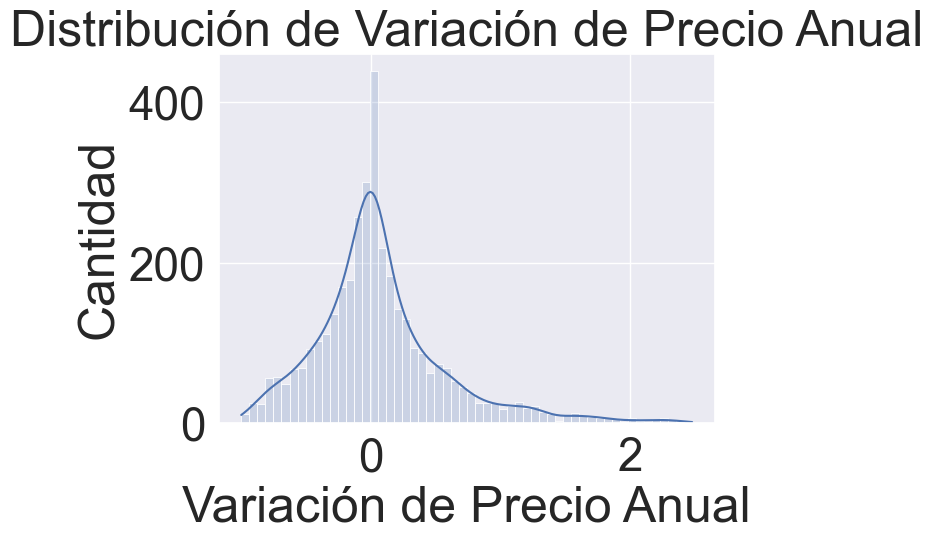

In [2051]:
# Distribucion de todo el dataset

fig = sns.histplot(df_MarketYearTrend3['Year_Price_Variation'], kde=True, alpha=0.2)
plt.title('Distribución de Variación de Precio Anual')
plt.xlabel('Variación de Precio Anual')
plt.xticks()
plt.ylabel('Cantidad')
plt.show


In [2052]:
df_MarketYearTrend3.describe()

MarketCap  YearFounded  MarketYearTrend          Mean        Median  \
count  3.637000e+03  2887.000000      3637.000000  3.637000e+03  3.637000e+03   
mean   4.584861e+09  1993.749567         0.009906  1.998548e+06  1.936382e+06   
std    2.441977e+10    45.750794         0.011134  1.021982e+08  1.014587e+08   
min    0.000000e+00    12.000000        -0.041000  1.919847e-04  1.000000e-04   
25%    1.170249e+08  1992.000000         0.005300  1.039933e+01  1.022000e+01   
50%    5.361622e+08  2002.000000         0.012900  1.748708e+01  1.719000e+01   
75%    2.183795e+09  2009.000000         0.017400  2.664393e+01  2.645000e+01   
max    7.270000e+11  2018.000000         0.031000  6.120341e+09  6.085800e+09   

          Stan Dev.  Year_Price_Variation  MC_discrete_classifier  
count  3.637000e+03           3637.000000             3637.000000  
mean   4.056950e+05              0.074980                1.615617  
std    1.793702e+07              0.517860                0.943485  
min    0.000000e+00             -0.999978                1.000000  
25%    9.280214e-01             -0.214667                1.000000  
50%    1.959391e+00              0.007179                1.000000  
75%    3.972122e+00              0.264171                2.000000  
max    1.056825e+09              2.477590                5.000000

In [2053]:
df = pd.DataFrame(df_MarketYearTrend3.groupby('Sector').count()['Symbol'])
df.rename(columns = {'Symbol':'Count'}, inplace = True)
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=df.index, y='Count', data = df)
plt.title('Empresas por Sector', fontsize=18, fontweight='bold')
plt.xlabel(None)
plt.ylabel('Cantidad',fontsize=15)
plt.xticks(fontsize=12)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', rotation_mode='anchor')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [2054]:
import plotly.graph_objects as go

# Use 'hole' to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=df.index, values=df.Count, hole=.3)])
fig.update_layout(
    title_text="Distribución de las Empresas por Sector",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Sector', x=0.5, y=0.5, font_size=20, showarrow=False)])

fig.show()

In [2055]:
df

Count
Sector                      
Basic Industries         139
Capital Goods            156
Consumer Durables         58
Consumer Non-Durables    102
Consumer Services        513
Energy                   175
Finance                  586
Health Care              551
Miscellaneous            103
No Specific Sector       652
Public Utilities         124
Technology               404
Transportation            74

In [2056]:
fig = make_subplots(rows=7, cols=2, subplot_titles=df_MarketYearTrend3.Sector.unique())
fig.update_layout(autosize=False, width=800,height=1800, showlegend=False)
xs = []
counterx = 1
countery = 1
count = 1
for i in df_MarketYearTrend3.Sector.unique():    
    df = df_MarketYearTrend3[df_MarketYearTrend3['Sector']==i]
    xs.append(df['Year_Price_Variation'])
    Sector = go.Histogram(x=xs[count-1])
    fig.append_trace(Sector, counterx, countery)
    
    if count%2 == 0:
        counterx += 1
    else:
        countery += 1
        
    if count %2 == 0:
        countery = 1
    count += 1

fig.show()

Vemos que de las 13 distribuciones, la que tiene una forma marcádamente diferente al resto es la de Consumer Durables (consumo discrecional). Por lo general es un sector que es muy sensible al momento macroeconómico general. El resto de distribuciones parecen ser de forma aproximadamente 'normal' sobre todo si se les acota más en cuanto al crecimiento anual (hasta 200% o 2x). De cualquier forma, sería importante realizar un test de normalidad para validar esta conclusión.

##### 2.1. ¿Las empresas de cuáles países se desempeñan mejor por sector? Incluir un estudio de EEUU vs Resto del mundo

In [2057]:
df_MarketYearTrend4.columns

Index(['Symbol', 'Sector', 'netIncome', 'MarketCap', 'YearFounded',
       'MarketYearTrend', 'Mean', 'Median', 'Stan Dev.',
       'Year_Price_Variation', 'MC_discrete_classifier'],
      dtype='object')

In [2058]:
df = df_main_clean[['Symbol', 'USACompany']]
df_MarketYearTrend5 = pd.merge(df_MarketYearTrend4, df, on=['Symbol'], how='inner')
df_MarketYearTrend5.drop_duplicates(subset='Symbol', inplace=True)

In [2059]:
df = df_MarketYearTrend5
fig = sns.histplot(df, x="Year_Price_Variation", hue="USACompany", multiple='stack')
plt.xlabel('Variacion de Precio Anual')
plt.ylabel('Cantidad')
plt.show()

El histograma apilado muestra la proporción de empresas de EEUU vs Resto del Mundo vs Origen desconocido y se ve la clara preponderancia de las empresas del país norteamericano pero pareciera que se distribuyen de igual manera en relación al tamaño sin importar el origen.  

A continuación mostraremos las distribuciones en conjunto y luego por separado para mayor claridad y además las proporciones exactas del lugar de origen de las empresas:

In [2060]:
group_labels = df_MarketYearTrend5.USACompany.unique()
df = df_MarketYearTrend5[df_MarketYearTrend5['USACompany']== group_labels[0]]
df2 = df_MarketYearTrend5[df_MarketYearTrend5['USACompany']== group_labels[1]]
df3 = df_MarketYearTrend5[df_MarketYearTrend5['USACompany']== group_labels[2]]

hist_data = [df["Year_Price_Variation"], df2["Year_Price_Variation"], df3["Year_Price_Variation"]]
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_curve=True, curve_type='normal')
fig.update_layout(xaxis_range=[-1,2], bargap=0.01)

fig.show()


print("\033[1m"+"Media, Mediana y Desviacion Estandar por lugar de origen"+"\033[0m")
print("EEUU: ", round(df['Year_Price_Variation'].mean(),2), round(df['Year_Price_Variation'].median(),2), round(df['Year_Price_Variation'].std(), 2))
print("Extranjeras: ", round(df2['Year_Price_Variation'].mean(),2), round(df2['Year_Price_Variation'].median(),2), round(df2['Year_Price_Variation'].std(), 2))
print("Origen Desconocido: ",round(df3['Year_Price_Variation'].mean(),2), round(df3['Year_Price_Variation'].median(),2), round(df3['Year_Price_Variation'].std(), 2))



Media, Mediana y Desviacion Estandar por lugar de origen
EEUU:  0.11 0.03 0.55
Extranjeras:  0.06 -0.01 0.59
Origen Desconocido:  0.0 -0.01 0.35


En los tres casos de lugar de origen, el crecimiento medio es muy optimista (mayor al 10%, cuando el S&P crece al 10%). Sin embargo, la mediana muestra la verdadera cara de invertir en empresas que recién salen a cotizar: muchas de ellas no obtienen una buena adopción en el mercado en su primer año. En cuanto a desviación estándar se refiere, las empresas de origen desconocido son las más predecibles, pero recordemos que son las que peores resultados de media y mediana obtuvieron.

In [2061]:
df_MarketYearTrend5.USACompany.value_counts()

Yes        2212
Unknown     873
No          552
Name: USACompany, dtype: int64

##### 61.4% de las compañías del DF son de origen estadounidense, mientras que 23.4% son extranjeras y el restante 15.2% son de origen desconocido.

In [2062]:
fig = make_subplots(rows=3, cols=1, subplot_titles=df_MarketYearTrend5.USACompany.unique(), shared_xaxes=True)
fig.update_layout(autosize=False, width=800,height=1000, showlegend=False, xaxis_range=[-1,2])
xs = []
count = 1
for i in df_MarketYearTrend5.USACompany.unique():    
    df = df_MarketYearTrend5[df_MarketYearTrend5['USACompany']==i]
    xs.append(df['Year_Price_Variation'])
    USACompany = go.Histogram(x=xs[count-1])
    fig.append_trace(USACompany, count, 1)
    count += 1

    
fig['layout']['xaxis']['title']='First Year Growth'
fig['layout']['yaxis']['title']='Number of Companies'
fig['layout']['xaxis2']['title']='First Year Growth'
fig['layout']['yaxis2']['title']='Number of Companies'
fig['layout']['xaxis3']['title']='First Year Growth'
fig['layout']['yaxis3']['title']='Number of Companies'

fig.show()

Según los histogramas podemos ver que las distribuciones de las compañías americanas son similares a las de origen desconocido. Quizás muchas de las de origen desconocido sean efectivamente americanas.

En el siguiente box plot veremos como se distribuye la variacion de precios por sector separado por lugar de origen.

In [2063]:
df = df_MarketYearTrend5
fig = px.box(df, x="Sector", y="Year_Price_Variation", color="USACompany")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

El boxplot por sector permite percatarnos de que existen muchos 'outliers' en la mayoría de grupos divididos por lugar de origen y sector. Sin embargo, destaca el boxplot de empresas extranjeras de 'No Specific Sector'  debido a sus dimensiones. Esta forma extraña podría deberse a una baja cantidad de datos de dicho grupo. A continuación mostraremos una tabla con los datos divididos por sector y comprobaremos esta hipótesis.

In [2064]:
df_MarketYearTrend5.USACompany.value_counts()

df = df_MarketYearTrend5[df_MarketYearTrend5['USACompany']=='Yes']
df2 = df_MarketYearTrend5[df_MarketYearTrend5['USACompany']=='No']
df3 = df_MarketYearTrend5[df_MarketYearTrend5['USACompany']=='Unknown']

df =  df.groupby("Sector").count()
df2 = df2.groupby("Sector").count()
df3 = df3.groupby("Sector").count()

df =  df.sort_values('Symbol', ascending=False).reset_index()
df.drop(axis=1,columns=df.columns[2:], inplace=True)

df2 =  df2.sort_values('Symbol', ascending=False).reset_index()
df2.drop(axis=1,columns=df2.columns[2:], inplace=True)

df3 =  df3.sort_values('Symbol', ascending=False).reset_index()
df3.drop(axis=1,columns=df3.columns[2:], inplace=True)

df.rename(columns={"Symbol":"USA"}, inplace=True)
df2.rename(columns={"Symbol":"Foreign"}, inplace=True)
df3.rename(columns={"Symbol":"Unknown"}, inplace=True)


df = pd.merge(df, df2, on=['Sector'], how='inner')
df = pd.merge(df, df3, on=['Sector'], how='inner')

df['Total'] = df['USA'] + df['Foreign'] + df['Unknown']

df.sort_values('Total', ascending=False, inplace=True)
df = df.reset_index()
df.drop(['index'], axis=1, inplace=True)
df

Sector  USA  Foreign  Unknown  Total
0      No Specific Sector   48        8      596    652
1                 Finance  426       80       80    586
2             Health Care  423       88       40    551
3       Consumer Services  407       59       47    513
4              Technology  277       97       30    404
5                  Energy  132       33       10    175
6           Capital Goods  116       32        8    156
7        Basic Industries   87       40       12    139
8        Public Utilities   78       28       18    124
9           Miscellaneous   76       19        8    103
10  Consumer Non-Durables   68       26        8    102
11         Transportation   28       36       10     74
12      Consumer Durables   46        6        6     58

Como se ve en la tabla, efectivamente, la categría extranjeras de 'No Specific Sector' cuenta con tan solo 8 datos. Esta tabla permite mostrar sobre cuáles subgrupos se pueden hacer análisis importantes y sobre cuales no es profesional hacerlo debido a la falta de datos.

##### 3.1. La relación entre la cantidad de empleados y el Market Cap

Es importante siempre considerar el impacto que puede tener cada sector en cuanto al número de empleados y el tamaño de la compañía. No será lo mismo una empresa del rubro de Tecnología, que suelen poder escalar en tamaño con menos empleados, que una empresa de consumo no duradero o de bienes básicos.En ambos casos, comprar un terreno y poner una planta llena de trbajadores es muy importante para incrementar sus ventas, versus una empresa que por ejemplo, te vende una licencia de software y no necesita muchos más empleados para vender más.

In [2065]:
df_MarketYearTrend6 = df_MarketYearTrend5

In [2066]:
df = df_main_clean[['Symbol', 'employees', 'employeesGrouped']]
df_MarketYearTrend6 = pd.merge(df_MarketYearTrend4, df, on=['Symbol'], how='inner')

In [2067]:
df_MarketYearTrend6.employeesGrouped.unique()

array(['>10000', '1001 - 5000', '101 - 500', '0 - 100', nan, '501 - 1000',
       'Blank', '5001 - 10000'], dtype=object)

In [2068]:
df_main_clean

Symbol                                    Name  DaysBetterThanSP  \
0         A              Agilent Technologies, Inc.               122   
1       AAC                      AAC Holdings, Inc.               131   
2      AAOI           Applied Optoelectronics, Inc.               125   
3       AAP                  Advance Auto Parts Inc               128   
4       AAT             American Assets Trust, Inc.               123   
...     ...                                     ...               ...   
3757   ZUMZ                             Zumiez Inc.               139   
3758    ZUO                             Zuora, Inc.                 5   
3759     ZX  China Zenix Auto International Limited               102   
3760   ZYME                          Zymeworks Inc.               115   
3761   ZYNE           Zynerba Pharmaceuticals, Inc.               104   

      daysProfit  Year  Month  Day  dayOfWeek  LastSale     MarketCap  \
0            249  1999     11   18          3     68.17  2.198323e+10   
1            262  2014     10    2          3     11.07  2.707691e+08   
2            262  2013      9   26          3     29.97  5.844368e+08   
3            261  2001     11   29          3    106.45  7.874971e+09   
4            127  2011      1   13          3     34.00  1.604956e+09   
...          ...   ...    ...  ...        ...       ...           ...   
3757         261  2005      5    6          4     24.10  6.085133e+08   
3758           7  2018      4   12          3     20.60  2.132269e+09   
3759          25  2011      5   12          3      1.30  6.711250e+07   
3760          19  2017      4   28          4     12.05  3.068106e+08   
3761          42  2015      8    5          2     10.02  1.358850e+08   

                 Sector                       Summary Quote  CEOTakeOver  \
0         Capital Goods     https://www.nasdaq.com/symbol/a       2015.0   
1           Health Care   https://www.nasdaq.com/symbol/aac       2013.0   
2            Technology  https://www.nasdaq.com/symbol/aaoi       2014.0   
3     Consumer Services   https://www.nasdaq.com/symbol/aap       2016.0   
4     Consumer Services   https://www.nasdaq.com/symbol/aat       2015.0   
...                 ...                                 ...          ...   
3757  Consumer Services  https://www.nasdaq.com/symbol/zumz       2011.0   
3758                NaN   https://www.nasdaq.com/symbol/zuo       2017.0   
3759      Capital Goods    https://www.nasdaq.com/symbol/zx          NaN   
3760        Health Care  https://www.nasdaq.com/symbol/zyme          NaN   
3761        Health Care  https://www.nasdaq.com/symbol/zyne       2014.0   

      CEOAge    CEOGender CEOInChargeDuringIPO FiscalDateEnd stateCountry  \
0       56.0         male                   No        18-Oct           CA   
1       46.0         male                  Yes        18-Dec           TN   
2       54.0      unknown                   No        18-Dec           TX   
3       59.0         male                   No        18-Dec           VA   
4       79.0         male                   No        18-Dec           CA   
...      ...          ...                  ...           ...          ...   
3757    57.0         male                   No        19-Jan           WA   
3758     NaN  mostly_male                  Yes        19-Jan           CA   
3759    47.0      unknown                  NaN        18-Dec        China   
3760     NaN          NaN                  NaN        18-Dec       Canada   
3761    59.0         male                  Yes        18-Dec           PA   

               City                                          Industry  \
0       Santa Clara  Biotechnology: Laboratory Analytical Instruments   
1         Brentwood                              Medical Specialities   
2        Sugar Land                                    Semiconductors   
3           Roanoke                            Other Specialty Stores   
4         San Diego                     Real Est

In [2069]:
df_MarketYearTrend6['employees'] = pd.to_numeric(df_MarketYearTrend6['employees'], errors='coerce')

In [2070]:
df_MarketYearTrend6.drop_duplicates(subset='Symbol', inplace=True)
df_MarketYearTrend6.shape

(3637, 13)

In [2071]:
bins = pd.IntervalIndex.from_tuples([(0, 100), (101, 500), (501, 1000), (1001, 5000), (5001, 10000), (10000, np.max(df_MarketYearTrend6.employees))], closed='left')
catDf = pd.cut(df_MarketYearTrend4["MarketCap"], bins = bins)
maximus_E = np.max(df_MarketYearTrend6.employees)
a = ('0 - 100', '101 - 500', '501 - 1000', '1001 - 5000', '5001 - 10000', f'10000 - {maximus_E}')


df_MarketYearTrend6['employeesGrouped'] = np.array(a)[pd.cut(df_MarketYearTrend6["employees"], bins = bins).cat.codes]

In [2072]:
bins = pd.IntervalIndex.from_tuples([(0, 1000000000), (1000000000, 5000000000), (5000000000, 10000000000), (10000000000, 100000000000), (100000000000, 1000000000000)], closed='left')
catDf = pd.cut(df_MarketYearTrend6["MarketCap"], bins = bins)
maximus_MC = round(np.max(df_MarketYearTrend6.MarketCap)/1000000000)
a = ('0 - 1B', '1B - 5B', '5B - 10B', '10B - 100B', f'100B - {maximus_MC}B')
df_MarketYearTrend6['MarketCapClassifier'] = np.array(a)[pd.cut(df_MarketYearTrend6["MarketCap"], bins = bins).cat.codes]

In [2073]:
df = df_MarketYearTrend6
fig = px.density_heatmap(df, x="MarketCapClassifier", y="employeesGrouped", marginal_x="histogram", text_auto=True)
fig.update_yaxes(categoryorder='array', categoryarray= ['0 - 100', '101 - 500', '501 - 1000', '1001 - 5000', '5001 - 10000', f'10000 - {maximus_E}'])
fig.update_xaxes(categoryorder='array', categoryarray= ['0 - 1B', '1B - 5B', '5B - 10B', '10B - 100B', f'100B - {maximus_MC}B'])
fig.show()

Como se ve en el gráfico de densidad 2D, 2297 empresas de 3696 (62%) no superan los mil millones (Billion) de capitalización de mercado en su primer año en bolsa. Este grupo además es el que concentra más empresas con el rango menor de empleados (0 a 100) lo cual tiene sentido. Sin embargo, su segundo rango más poblado es el máximo, lo cual es muy curioso. De hecho, este fenómeno ocurre en todas las capitalizaciones de mercado (el rango más  poblado es el de más empleados). Haciendo ver que no hay una relación tan clara entre tamaño o Market Cap y número de empleados. Sin embargo, sí podemos ver conforme nos movemos a la derecha del cuadro que tiende a haber una mayor proporción de empresas en la parte superior de la tabla que en la inferior, es decir, a más grande es la empresa, suele contratar más empleados.

In [2074]:
unique_sectors = df['Sector'].unique()
for i in unique_sectors:     
    df_sector = df[df['Sector'] == i]
    print(i)
    fig = px.density_heatmap(df_sector, x="MarketCapClassifier", y="employeesGrouped", marginal_x="histogram", text_auto=True)
    fig.update_yaxes(categoryorder='array', categoryarray= ['0 - 100', '101 - 500', '501 - 1000', '1001 - 5000', '5001 - 10000', f'10000 - {maximus_E}'])
    fig.update_xaxes(categoryorder='array', categoryarray= ['0 - 1B', '1B - 5B', '5B - 10B', '10B - 100B', f'100B - {maximus_MC}B'])
    fig.show()


Capital Goods


Health Care


Technology


Consumer Services


Energy


Transportation


No Specific Sector


Consumer Non-Durables


Consumer Durables


Finance


Basic Industries


Miscellaneous


Public Utilities


In [2075]:
df_MarketYearTrend6.groupby('Sector').mean()['employees']

Sector
Basic Industries          6685.531532
Capital Goods            13050.154412
Consumer Durables         8228.895833
Consumer Non-Durables    13821.845238
Consumer Services        11243.242131
Energy                   10150.874126
Finance                   6176.810155
Health Care               3820.944898
Miscellaneous            12843.763441
No Specific Sector        1123.750000
Public Utilities         12407.906977
Technology                6568.273529
Transportation           14107.509434
Name: employees, dtype: float64

In [2076]:
df_MarketYearTrend6.groupby('Sector')[['employees', 'MarketCap']].corr().unstack().iloc[:,1]

Sector
Basic Industries         0.485413
Capital Goods            0.716538
Consumer Durables        0.959652
Consumer Non-Durables    0.484425
Consumer Services        0.287893
Energy                   0.750223
Finance                  0.465478
Health Care              0.513597
Miscellaneous            0.250875
No Specific Sector       0.426136
Public Utilities         0.468432
Technology               0.311363
Transportation           0.932620
Name: (employees, MarketCap), dtype: float64

In [2077]:
df = pd.DataFrame(df_MarketYearTrend6.groupby('Sector')[['employees', 'MarketCap']].corr().unstack().iloc[:,1])
df.columns = df.columns.droplevel(0)
df = df.round(2)
df.rename(columns = {'MarketCap':'Corr employees vs MC'}, inplace=True)
df.sort_values(by=['Corr employees vs MC'], ascending=False, inplace=True)
df.T

Sector                Consumer Durables  Transportation  Energy  \
Corr employees vs MC               0.96            0.93    0.75   

Sector                Capital Goods  Health Care  Basic Industries  \
Corr employees vs MC           0.72         0.51              0.49   

Sector                Consumer Non-Durables  Finance  Public Utilities  \
Corr employees vs MC                   0.48     0.47              0.47   

Sector                No Specific Sector  Technology  Consumer Services  \
Corr employees vs MC                0.43        0.31               0.29   

Sector                Miscellaneous  
Corr employees vs MC           0.25

Las empresas de todos los sectores suelen seguir la tendencia general de mayor escala igual a mayor número de empleados. Sin embargo, los gráficos muestras que efectivamente sectores como la tecnología y curionasmente el la Energía, no la siguen tan de cerca. Este hallazgo es interesante porque revaloriza escalar sin mayor inversión adicional en mano de obra. Considerando que es de los mayores costos de muchas empresas, significa que al crecer, compañías de estos sectores rápidamente expanden sus márgenes.

## 4. Longevidad de la Empresa
##### 4.1. Una empresa antigua debería tender a hacerlo mejor en su primer año de cotización en mercados públicos

Lógicamente una empresa que viene siendo gestionada por más años antes de salir a cotizar en bolsa debería estar mejor organizada y por ende verse como una opción más sólida para invertir que una empresa que no a sobrevivido a la "prueba del tiempo". Un comportamiento relacionado a la solidez no necesariamente es hacerlo mejor en términos de incremento de valorización, sino, qué tanta variabilidad hay entre empresas nuevas vs las experimentadas.

In [2078]:
df_CompanyAge = df_MarketYearTrend6

In [2079]:
df = df_main_clean[['Symbol', 'Year']]
df_CompanyAge = pd.merge(df_CompanyAge, df, on=['Symbol'], how='inner')

In [2080]:
df_CompanyAge.drop_duplicates(subset='Symbol',inplace=True)

In [2081]:
df_CompanyAge.shape

(3637, 15)

In [2082]:
# Feature Engineering (YearsBeforeIpo)
df_CompanyAge['YearsBeforeIpo'] = df_CompanyAge['Year'] - df_CompanyAge['YearFounded']

(array([0.  , 0.01, 0.02, 0.03, 0.04]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.01, '0.01'),
  Text(0, 0.02, '0.02'),
  Text(0, 0.03, '0.03'),
  Text(0, 0.04, '0.04')])

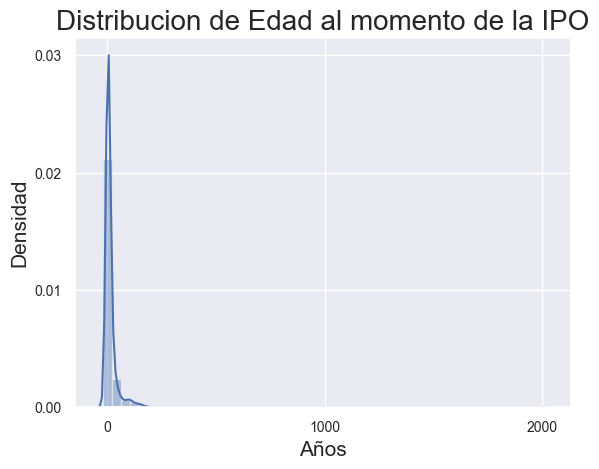

In [2083]:
sns.distplot(df_CompanyAge['YearsBeforeIpo'])
plt.title('Distribucion de Edad al momento de la IPO', fontsize = 20, fontweight = 20)
plt.xlabel('Años', fontsize = 15, fontweight = 20)
plt.ylabel('Densidad', fontsize = 15, fontweight = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

In [2084]:
# eliminar compañías de más de 200 años de antiguedad (hay un dato de 2000 años)
index_year_price_change = df_CompanyAge[(df_CompanyAge['YearsBeforeIpo'] > 200)].index
df_CompanyAge.drop(index_year_price_change , inplace=True)

In [2085]:
df = df_CompanyAge
fig = px.scatter(df, x="YearsBeforeIpo", y="Year_Price_Variation", hover_data=['Symbol'], color="Sector", size='MC_discrete_classifier') 

fig.update_layout(yaxis_tickformat = '0%', xaxis_tickformat = '0')

fig.show()

Una empresa más antigua no lo hará necesariamente mejor en bolsa en su primer año de cotización, pero sí será más predecible el rango sobre el cual fluctuará el incremento en su valoración según el gráfico. Además, viendo el tamaño de las burbujas, parece que las empresas con mayor Market Cap suelen tener también un rango más acotado. Con estos dos hallazgos podemos suponer que si lo que se busca son rendimientos más predecibles pero menores, empresas grandes y con más edad son la mejor opción cuando salen a cotizar.

Evaluando los gráficos, tiene sentido que una empresa nueva rinda más con mucho mayor riesgo debido a que tiene un mayor potencial de crecimiento. El tema de sobrevivir la "prueba del tiempo", parece ser relevante en cuanto a un rango más acotado de incremento de valorización.

## 5. Volatilidad
##### 5.1. La distribución de la capitalización de mercado de las IPO's

Tiene sentido esperar tener muchas empresas de bajas capitalizaciones y algunos outliers que puedan sesgar la media de la capitalización. Este comportamiento es muy común en la conducta humana donde subyace el concepto de "the winner takes all".

In [2086]:
# Entendiendo las variaciones en el Market Cap
df = df_MarketYearTrend3
fig = px.histogram(df, x="MarketCap", color="Sector")
fig.show()

In [2087]:
# Entendiendo las variaciones en el Market Cap, limitamos a 100B
num_rows_100B = len(df_MarketYearTrend3[df_MarketYearTrend3['MarketCap'] > 100000000000].index)

df = df_MarketYearTrend3
fig = px.histogram(df, x="MarketCap", color="Sector", range_x = [0,100000000000])
fig.show()

In [2088]:
# Entendiendo las variaciones en el Market Cap, limitamos a 10B y aumentamos el numero de bins para visualizar mejorar 
# la distribucion de los datos
num_rows_10B = len(df_MarketYearTrend3[df_MarketYearTrend3['MarketCap'] > 10000000000].index)

df = df_MarketYearTrend3
fig = px.histogram(df, x="MarketCap", color="Sector", range_x = [0,10000000000], nbins=1000)
fig.show()

In [2089]:
# Empresas mayores a 100B de Capitalizacion de Mercado
print(f'Datos mayores a 100B de Market Cap: {num_rows_100B}')
print(f'Equivale a '"{0:.2%}".format(num_rows_100B/df_MarketYearTrend3.shape[0])+' del total de datos')
print('-----------------------------------------------')
# Empresas mayores a 10B de Capitalizacion de Mercado
print(f'Datos mayores a 10B de Market Cap: {num_rows_10B}')
print(f'Equivale a '"{0:.2%}".format(num_rows_10B/df_MarketYearTrend3.shape[0])+' del total de datos')

Datos mayores a 100B de Market Cap: 22
Equivale a 0.60% del total de datos
-----------------------------------------------
Datos mayores a 10B de Market Cap: 300
Equivale a 8.25% del total de datos


Como se ve en los gráficos de distribución, los datos se encuentran sesgados a la derecha, es decir, apilados cerca al eje 'Y'. Esto tiene sentido ya que es muy difícil alcanzar una  capitalización de mercado muy alta y a menudo unas pocas empresas se suelen quedar con desproporcionalmente más mercado ("the winner takes all").

##### 5.2. Cómo se relacionan la capitalización de mercado con la variación de la cotización anual y la volatilidad diaria

Tiene sentido esperar que la relación entre Market Cap y la variación en la cotización anual sea inversa. Esto debido a que a mayor valor, más masa monetaria (ingresos o salidas de capital) se necesitarán para mover el precio de una acción. Sin ambargo, es preciso tener en cuenta que en última instancia la liquidez es el factor determinante. Por ejemplo, una empresa muy grande puede fluctuar mucho en bolsa si muy poquitos de sus inversores desean vender.

In [2090]:
features1=list(['MarketCap', 'Year_Price_Variation', 'Stan Dev.'])
features2=list(['MC_discrete_classifier', 'Year_Price_Variation', 'Stan Dev.'])

Debemos asegurar que la variacion sea de valor absoluto antes de realizar la correlación

In [2091]:
df = df_MarketYearTrend6

In [2092]:
df['Year_Price_Variation'] = df['Year_Price_Variation'].abs()

In [2093]:
df[features1].corr()

MarketCap  Year_Price_Variation  Stan Dev.
MarketCap              1.000000              0.033947  -0.004225
Year_Price_Variation   0.033947              1.000000   0.017351
Stan Dev.             -0.004225              0.017351   1.000000

Vemos que el Market Cap no está correlacionado ni con la variación anual, ni con la volatilidad diaria. A continación, veremos si el Market Cap visto por categorías (MC discreto) sí tiene alguna correlación al menos superior a 0.3.

In [2094]:
df[features2].corr()

MC_discrete_classifier  Year_Price_Variation  \
MC_discrete_classifier                1.000000              0.053283   
Year_Price_Variation                  0.053283              1.000000   
Stan Dev.                            -0.014762              0.017351   

                        Stan Dev.  
MC_discrete_classifier  -0.014762  
Year_Price_Variation     0.017351  
Stan Dev.                1.000000

Como se ve en la tabla, si bien hay pequeñas variaciones, ninguna correlación puede ser ni siquiera considerada como 'débil'. La correlación entre la variación de precio anual y la desviación estándar diaria será evaluada más adelante.

##### 5.3. Una mayor volatilidad debería tender a mayores retornos

Debido a que el mercado tiende a incrementar su valor, las empresas en el mismo que fluctuen mucho deberían tener mayores retornos. Ciertos grupos en finanzas suelen relacionar directamente la volatilidad con el riesgo, y a mayor riesgo, más posibilidad de ganar.

In [2095]:
df.groupby('Sector')[['Year_Price_Variation', 'Stan Dev.']].corr()

Year_Price_Variation  Stan Dev.
Sector                                                                     
Basic Industries      Year_Price_Variation              1.000000   0.040911
                      Stan Dev.                         0.040911   1.000000
Capital Goods         Year_Price_Variation              1.000000   0.020754
                      Stan Dev.                         0.020754   1.000000
Consumer Durables     Year_Price_Variation              1.000000   0.254166
                      Stan Dev.                         0.254166   1.000000
Consumer Non-Durables Year_Price_Variation              1.000000   0.186796
                      Stan Dev.                         0.186796   1.000000
Consumer Services     Year_Price_Variation              1.000000   0.144915
                      Stan Dev.                         0.144915   1.000000
Energy                Year_Price_Variation              1.000000   0.131299
                      Stan Dev.                         0.131299   1.000000
Finance               Year_Price_Variation              1.000000   0.030727
                      Stan Dev.                         0.030727   1.000000
Health Care           Year_Price_Variation              1.000000   0.025662
                      Stan Dev.                         0.025662   1.000000
Miscellaneous         Year_Price_Variation              1.000000   0.380864
                      Stan Dev.                         0.380864   1.000000
No Specific Sector    Year_Price_Variation              1.000000   0.144278
                      Stan Dev.                         0.144278   1.000000
Public Utilities      Year_Price_Variation              1.000000   0.239941
                      Stan Dev.                         0.239941   1.000000
Technology            Year_Price_Variation              1.000000   0.014995
                      Stan Dev.                         0.014995   1.000000
Transportation        Year_Price_Variation              1.000000   0.045997
                      Stan Dev.                         0.045997   1.000000

Otra vez vemos que no existe ninguna correlación significativa entre la variación anual y la volatilidad. Esta hipótesis demuestra que ningún sector posee esta correlación y por lo tanto, para este dataset, esta hipótesis es falsa.

##### 5.4. ¿Hay relación entre el volumen diario medio como porcentaje del Market Cap de una acción y su volatilidad diaria?

En teoría, a mayor número de acciones comercializadas debería haber menor volatilidad en los precios de la misma.

In [2096]:
df = df_volumeDay_prices_clean

In [2097]:
df

Symbol  volumeDay0  volumeDay1  volumeDay2  volumeDay3  volumeDay4  \
0         A  59753154.0  16172993.0   5435127.0   5035889.0   5141708.0   
1       AAC   2799073.0    155562.0    188229.0    176606.0     37046.0   
2      AAOI    948999.0    253329.0     84885.0     74509.0     94046.0   
3       AAP    371100.0    165300.0    127500.0     95400.0    598200.0   
4       AAT  15536889.0   1304772.0         0.0    493070.0   1010169.0   
...     ...         ...         ...         ...         ...         ...   
3757   ZUMZ   6793424.0    805032.0    358766.0    282498.0    252255.0   
3758    ZUO  13102419.0   1864667.0    907867.0   1152504.0    886009.0   
3759     ZX   4987284.0   6707576.0    515136.0    321123.0    162260.0   
3760   ZYME    953887.0     97009.0     68578.0     40809.0     33256.0   
3761   ZYNE   1535500.0    331792.0    269397.0    539255.0    243632.0   

      volumeDay5  volumeDay6  volumeDay7  volumeDay8  volumeDay9  volumeDay10  \
0            0.0   1836047.0   4325867.0   4575651.0   3139581.0    3259056.0   
1       114523.0     34775.0     52514.0    126457.0     46156.0      61787.0   
2        72425.0    109774.0     52731.0     13890.0     14788.0      80330.0   
3       157200.0    215100.0    119100.0    378600.0    114600.0     113700.0   
4       736532.0    636750.0    354269.0    295652.0    346772.0     450330.0   
...          ...         ...         ...         ...         ...          ...   
3757    154172.0    102162.0     80208.0    341784.0     93574.0     230708.0   
3758    463459.0    300461.0    300461.0    300461.0    300461.0     300461.0   
3759    787028.0    174288.0     95852.0    113431.0    134606.0     296569.0   
3760     20538.0     11444.0     72822.0     13474.0     19341.0       5444.0   
3761    238014.0    407807.0    233090.0    124093.0    141591.0     119814.0   

      volumeDay11  volumeDay12  volumeDay13  volumeDay14  volumeDay15  \
0       3229076.0    2389489.0    2352534.0    2004202.0    2154102.0   
1         90567.0      71667.0      91042.0     312342.0      80998.0   
2         23700.0      64386.0      10182.0       7081.0      63082.0   
3        233400.0     106200.0     101400.0     157800.0      97200.0   
4        475217.0     197572.0     560838.0     168253.0     549365.0   
...           ...          ...          ...          ...          ...   
3757     113834.0      60570.0     226600.0     319204.0     289858.0   
3758     300461.0     300461.0     300461.0     300461.0     300461.0   
3759     150548.0          0.0     337697.0     278244.0     288082.0   
3760      24829.0      21942.0       9240.0       7695.0       7427.0   
3761     156474.0     140695.0      52600.0      64648.0     113266.0   

      volumeDay16  volumeDay17  volumeDay18  volumeDay19  volumeDay20  \
0       1767331.0    3320798.0    1563409.0    3097580.0    2031512.0   
1        155610.0     200604.0      54810.0     197761.0      65404.0   
2        154212.0     252626.0     321195.0      64997.0      74727.0   
3        659400.0      50700.0          0.0     378000.0     349200.0   
4        219587.0     454867.0     247100.0     423861.0     255985.0   
...           ...          ...          ...          ...          ...   
3757          0.0     198986.0     662872.0     434534.0      49982.0   
3758     300461.0     300461.0     300461.0     300461.0     300461.0   
3759     232651.0     131767.0     116749.0     177138.0      74343.0   
3760      12802.0      36178.0      19816.0       9824.0      16456.0   
3761     145750.0      61751.0     175419.0      19640.0      80185.0   

      volumeDay21  volumeDay22  volumeDay23  volumeDay24  volumeDay25  \
0       3936573.0    1270584.0    2398691.0    2023199.0    2292574.0   
1        310829.0      43862.0      31693.0      39658.0     488797.0   
2        130249.0      67819.0     180066.0     133451.0      89273.0   
3        295500.0     255300.0          0.0     132300.0      89700.0   
4        175

In [2098]:
df2 = df.drop(df.columns[1:-3],axis = 1)

In [2099]:
df2 = df2.drop(df2.columns[2:], axis =1)

In [2100]:
df_MarketYearTrend6

Symbol              Sector netIncome     MarketCap  YearFounded  \
0         A       Capital Goods  $684.00M  2.198323e+10       1999.0   
1       AAC         Health Care  $-20.58M  2.707691e+08       2014.0   
2      AAOI          Technology   $73.95M  5.844368e+08       1997.0   
3       AAP   Consumer Services  $475.51M  7.874971e+09       1929.0   
4       AAT   Consumer Services   $29.08M  1.604956e+09       2010.0   
...     ...                 ...       ...           ...          ...   
3695   ZUMZ   Consumer Services   $26.80M  6.085133e+08       1978.0   
3696    ZUO  No Specific Sector  $-47.16M  2.132269e+09       2007.0   
3697     ZX       Capital Goods    $1.34M  6.711250e+07       2008.0   
3698   ZYME         Health Care  $-10.41M  3.068106e+08       2003.0   
3699   ZYNE         Health Care  $-32.01M  1.358850e+08       2007.0   

      MarketYearTrend       Mean   Median  Stan Dev.  Year_Price_Variation  \
0              0.0204  46.378060  44.8908  16.334874              0.114706   
1              0.0088  30.168664  29.5400   7.078500              0.320541   
2              0.0144  18.051160  18.4200   4.599134              0.687751   
3             -0.0075  16.715145  16.7000   1.840810              0.236187   
4              0.0226  20.724008  21.1500   1.295989              0.026353   
...               ...        ...      ...        ...                   ...   
3695           0.0055  20.283076  17.8850   5.973934              1.800161   
3696           0.0079  19.726260  19.7200   0.079838              0.014000   
3697           0.0149   4.346186   4.2800   0.842612              0.408547   
3698           0.0174   9.561016   8.8000   1.940077              0.078462   
3699           0.0084  12.007557   9.6700   6.526545              0.353846   

      MC_discrete_classifier  employees  employeesGrouped MarketCapClassifier  
0                          4    13500.0  10000 - 494297.0          10B - 100B  
1                          1     2100.0       1001 - 5000              0 - 1B  
2                          1     3054.0       1001 - 5000              0 - 1B  
3                          3    71000.0  10000 - 494297.0            5B - 10B  
4                          2      194.0         101 - 500             1B - 5B  
...                      ...        ...               ...                 ...  
3695                       1     8900.0      5001 - 10000              0 - 1B  
3696                       2      933.0        501 - 1000             1B - 5B  
3697                       1        NaN  10000 - 494297.0              0 - 1B  
3698                       1      147.0         101 - 500              0 - 1B  
3699                       1       22.0           0 - 100              0 - 1B  

[3637 rows x 14 columns]

In [2101]:
df = df_MarketYearTrend6[['Symbol', 'Year_Price_Variation', 'MarketCap']]
df3 = pd.merge(df2, df, on=['Symbol'], how='inner')
df3.rename(columns = {'Mean':'mean_daily_traded_volume','Stan Dev.':'year_price_variation_std'}, inplace=True)

In [2102]:
df4 = df3

In [2103]:
df4['proportion_daily_vol_of_MC'] = df4['mean_daily_traded_volume']/df4['MarketCap']

In [2104]:
df4

Symbol  mean_daily_traded_volume  Year_Price_Variation     MarketCap  \
0         A              4.224553e+06              0.114706  2.198323e+10   
1       AAC              2.750787e+05              0.320541  2.707691e+08   
2      AAOI              1.740732e+05              0.687751  5.844368e+08   
3       AAP              1.072827e+06              0.236187  7.874971e+09   
4       AAT              2.994157e+05              0.026353  1.604956e+09   
...     ...                       ...                   ...           ...   
3695   ZUMZ              2.259203e+05              1.800161  6.085133e+08   
3696    ZUO              3.637211e+05              0.014000  2.132269e+09   
3697     ZX              9.027839e+04              0.408547  6.711250e+07   
3698   ZYME              2.534514e+04              0.078462  3.068106e+08   
3699   ZYNE              1.787730e+05              0.353846  1.358850e+08   

      proportion_daily_vol_of_MC  
0                       0.000192  
1                       0.001016  
2                       0.000298  
3                       0.000136  
4                       0.000187  
...                          ...  
3695                    0.000371  
3696                    0.000171  
3697                    0.001345  
3698                    0.000083  
3699                    0.001316  

[3700 rows x 5 columns]

In [2105]:
df4.drop(df4[['mean_daily_traded_volume', 'MarketCap']], axis=1, inplace=True)

Debemos asegurar que la variacion sea de valor absoluto antes de realizar la correlación

In [2106]:
df4['Year_Price_Variation'] = df4['Year_Price_Variation'].abs()

In [2107]:
df4.corr()

Year_Price_Variation  proportion_daily_vol_of_MC
Year_Price_Variation                    1.000000                    0.047397
proportion_daily_vol_of_MC              0.047397                    1.000000

La proporción del valor de las acciones vendidas en relación al Market Cap de la compañía no está correlacionada con la variación anual del precio de la acción

## 6. Ratios financieros: P/E to growth
##### 6.1. ¿Cuál es la relación entre el P/E del año anterior a cotizar con la cotización en el primer año en bolsa? Diferenciar por sector

El P/E es un indicador del precio de una acción relativo al número de veces de esta sobre los EPS (ingresos netos por acción). Ya que indica el "número de veces" forma parte de los indicadores conocidos como "múltiplos". Generamente un P/E por debajo de la media indica que la empresa está subvaluada y por ende tiene más probabilidades de aumentar su cotización en el futuro.

Probaremos esta hipótesis diferenciada por sector (ya que influye en el P/E) y deberíamos esperar una correlación negativa entre el P/E del año antes de salir a cotizar con la variación del precio en bolsa.

In [2108]:
# Armamos un DF para calcular el P/E de cada empresa por sector
df_closeDay_prices_clean["Year_Price_Variation"] = (df_closeDay_prices_clean['closeDay261'] - df_closeDay_prices_clean['closeDay0'])/df_closeDay_prices_clean['closeDay0']
df_PE = df_main_clean[['Symbol','Sector','netIncome', 'MarketCap', 'Year', 'YearFounded']]
df_PE2 = pd.merge(df_PE, df_closeDay_prices_clean, on=['Symbol'], how='inner')
df_PE2.drop(df_PE2.iloc[:,4:-4], axis=1, inplace=True)
df_PE2 = df_PE2.drop_duplicates(subset='Symbol')

In [2109]:
# Eliminar compañias con variaciones mayores al 250% (se multiplica 2.5x su cotización en bolsa el primer año).
index_year_price_change = df_PE2[(df_PE2['Year_Price_Variation'] >= 2.5)].index
df_PE2.drop(index_year_price_change , inplace=True)
df_PE2.shape

(3637, 8)

In [2110]:
print(df_PE.shape)
print(df_PE2.shape)
print(df_closeDay_prices_clean.shape)

(3762, 6)
(3637, 8)
(3762, 267)


In [2111]:
df_PE3 = df_PE2
df_PE3['netIncome'] = df_PE3['netIncome'].str[1:-1]
df_PE3.netIncome.value_counts(dropna=False)

NaN       877
-9.77       4
-13.61      4
1.28        4
5.94        4
         ... 
-34.43      1
-2.51       1
-60.54      1
-29.99      1
-32.01      1
Name: netIncome, Length: 2473, dtype: int64

Vemos que existen 881 NaNs de un total de 3699 datos en la columna 'netIncome'. Estos datos deberan ser eliminados.

In [2112]:
df_PE3.dtypes

Symbol                   object
Sector                   object
netIncome                object
MarketCap               float64
Mean                    float64
Median                  float64
Stan Dev.               float64
Year_Price_Variation    float64
dtype: object

##### El tipo de dato de netIncome es un 'object', esto nos dará un error si lo intentamos usar para sacar el P/E ya que MarketCap es float. Deberemos corregir esto antes de realizar cualquier cálculo.

In [2113]:
df_PE3 = df_PE3.dropna()
df_PE3 = df_PE3.reset_index()

In [2114]:
df_PE3['netIncome'] = pd.to_numeric(df_PE3['netIncome'], errors='coerce')
df_PE3['netIncome'] = df_PE3['netIncome']*1000000
print(df_PE3.dtypes)

index                     int64
Symbol                   object
Sector                   object
netIncome               float64
MarketCap               float64
Mean                    float64
Median                  float64
Stan Dev.               float64
Year_Price_Variation    float64
dtype: object


In [2115]:
df_PE3['P/E'] = round(df_PE3['MarketCap']/df_PE3['netIncome'])

In [2116]:
df_PE3.groupby('Sector')[['P/E','Year_Price_Variation']].corr().unstack().iloc[:,1]

Sector
Basic Industries         0.137742
Capital Goods            0.072245
Consumer Durables        0.040569
Consumer Non-Durables   -0.033404
Consumer Services        0.010963
Energy                   0.059811
Finance                  0.052686
Health Care              0.023654
Miscellaneous            0.047497
Public Utilities         0.098921
Technology               0.118547
Transportation          -0.054626
Name: (P/E, Year_Price_Variation), dtype: float64

Al parecer si bien la correlación es negativa para la mayoría de sectores vs el P/E del año anterior, estas son muy bajas y difícilmente serán siginificativas. Puede deberse a que quizás otras variables estén influyendo (como el país de origen o el momento en que salieron a cotizar). También podría no ser cierta la hipótesis para variación de precios de una IPO después de tan solo 1 año de cotizar públicamente.

In [2117]:
fig = make_subplots(rows=7, cols=2, subplot_titles=df_PE3.Sector.unique())
fig.update_layout(autosize=False, width=800,height=1800, showlegend=False)
xs = []
ys = []
counterx = 1
countery = 1
count = 1
for i in df_PE3.Sector.unique():    
    df = df_PE3[df_PE3['Sector']==i]
    xs.append(df['P/E'])
    ys.append(df['Year_Price_Variation'])

    Sector = go.Scatter(x=xs[count-1], y=ys[count-1], mode='markers')
    fig.append_trace(Sector, counterx, countery)
    
    if count%2 == 0:
        counterx += 1
    else:
        countery += 1
        
    if count %2 ==0:
        countery = 1
    count += 1

fig.show()

Usualmente la media del S&P para el P/E es 18, por lo que eliminaremos los datos mayores a 200 (rara vez se encuentran datos mayores a 100 y generalmente es una valoración insostenible en el tiempo. Tampoco se suele usar valores de multiplos negativos.

In [2118]:
# Eliminar compañias con valoraciones superiores a 200 o con multiplos menores a 0.
df_PE4 = df_PE3
index_PE = df_PE4[(df_PE4['P/E'] >= 200)].index
df_PE4.drop(index_PE , inplace=True)
index_PE = df_PE4[(df_PE4['P/E'] <= 0)].index
df_PE4.drop(index_PE , inplace=True)
df_PE4.reset_index(inplace=True)

In [2119]:
df_PE4.drop(['level_0','index'], axis=1)

Symbol             Sector    netIncome     MarketCap       Mean   Median  \
0         A      Capital Goods  684000000.0  2.198323e+10  46.378060  44.8908   
1      AAOI         Technology   73950000.0  5.844368e+08  18.051160  18.4200   
2       AAP  Consumer Services  475510000.0  7.874971e+09  16.715145  16.7000   
3       AAT  Consumer Services   29080000.0  1.604956e+09  20.724008  21.1500   
4       AAV             Energy   95040000.0  5.857840e+08   6.075099   6.0750   
...     ...                ...          ...           ...        ...      ...   
1285   ZNGA         Technology   26630000.0  3.080763e+09   6.692469   5.7300   
1286    ZTO     Transportation  467530000.0  1.127765e+10  13.925878  14.0100   
1287    ZTS        Health Care  864000000.0  4.094335e+10  31.860534  31.8100   
1288   ZUMZ  Consumer Services   26800000.0  6.085133e+08  20.283076  17.8850   
1289     ZX      Capital Goods    1340000.0  6.711250e+07   4.346186   4.2800   

      Stan Dev.  Year_Price_Variation    P/E  
0     16.334874              0.114706   32.0  
1      4.599134              0.687751    8.0  
2      1.840810              0.236187   17.0  
3      1.295989             -0.026353   55.0  
4      0.973293             -0.068069    6.0  
...         ...                   ...    ...  
1285   4.016965             -0.732632  116.0  
1286   1.084280             -0.050694   24.0  
1287   1.182827             -0.020961   47.0  
1288   5.973934              1.800161   23.0  
1289   0.842612             -0.408547   50.0  

[1290 rows x 9 columns]

In [2120]:
df_PE4.Year_Price_Variation.max()

2.4340571428571427

In [2121]:
fig = make_subplots(rows=7, cols=2, subplot_titles=df_PE4.Sector.unique())
fig.update_layout(autosize=False, width=800,height=1800, showlegend=False)
xs = []
ys = []
counterx = 1
countery = 1
count = 1
for i in df_PE4.Sector.unique():    
    df = df_PE4[df_PE4['Sector']==i]
    xs.append(df['P/E'])
    ys.append(df['Year_Price_Variation'])

    Sector = go.Scatter(x=xs[count-1], y=ys[count-1], mode='markers')
    fig.append_trace(Sector, counterx, countery)
    
    if count%2 == 0:
        counterx += 1
    else:
        countery += 1
        
    if count %2 ==0:
        countery = 1
    count += 1

fig.show()

En Health Care, Technology, Energy y Miscellaneous parece comprobarse el efecto inverso del P/E sobre la variación del precio (a menor P/E, mayor potencial de revalorización). Sin embargo los resultados en general son decepcionantes en cuanto a esta hipótesis. Parece que en el caso de empresas que recién salen a cotizar, el P/E del año previo a salir a bolsa no parece ser muy relevante, puede deberse a que no hay un historial público como para determinar si la empresa está cara o barata respecto a su histórico y solo se le puede contrastar con el sector. Otra explicación es que la euforia de la salida a bolsa minimice el efecto de una valoración razonble basada en el múltiplo P/E. Finalmente, quizás este indicador sí tenga un peso significativo ya que hay sectores donde parece influir, pero no sea algo muy importante.

# 7. Reducción de dimensionalidad y selección del método de aprendizaje supervisado

#### 7.1. Reducción de dimensionalidad: Utilizando un mapa de calor reduciremos el número de variables.

In [2122]:
df_CompanyAge.columns

Index(['Symbol', 'Sector', 'netIncome', 'MarketCap', 'YearFounded',
       'MarketYearTrend', 'Mean', 'Median', 'Stan Dev.',
       'Year_Price_Variation', 'MC_discrete_classifier', 'employees',
       'employeesGrouped', 'MarketCapClassifier', 'Year', 'YearsBeforeIpo'],
      dtype='object')

In [2123]:
df = df_main_clean[['Symbol', 'DaysBetterThanSP', 'daysProfit', 'dayOfWeek', 'LastSale',
       'Summary Quote', 'CEOTakeOver', 'CEOAge', 'CEOGender', 'FiscalDateEnd',
       'Revenue', 'Market6MonthTrend', 'USACompany', 'FiscalMonth',
       'Profitable', 'Safe', 'City', 'stateCountry', 'Industry']]
df_main_clean2 = pd.merge(df_CompanyAge, df, on=['Symbol'], how='inner')
df_main_clean2.dtypes

Symbol                     object
Sector                     object
netIncome                  object
MarketCap                 float64
YearFounded               float64
MarketYearTrend           float64
Mean                      float64
Median                    float64
Stan Dev.                 float64
Year_Price_Variation      float64
MC_discrete_classifier      int64
employees                 float64
employeesGrouped           object
MarketCapClassifier        object
Year                        int64
YearsBeforeIpo            float64
DaysBetterThanSP            int64
daysProfit                  int64
dayOfWeek                   int64
LastSale                  float64
Summary Quote              object
CEOTakeOver               float64
CEOAge                    float64
CEOGender                  object
FiscalDateEnd              object
Revenue                    object
Market6MonthTrend         float64
USACompany                 object
FiscalMonth                object
Profitable    

## Numero de variables por categoria en Industry, stateCountry y City

In [2124]:
df_main_clean2.groupby('Industry')['Industry'].count()

Industry
Accident &Health Insurance            4
Advertising                          11
Aerospace                             7
Agricultural Chemicals               10
Air Freight/Delivery Services        12
                                     ..
Tobacco                               1
Transportation Services              14
Trucking Freight/Courier Services     6
Water Supply                          6
Wholesale Distributors                2
Name: Industry, Length: 132, dtype: int64

In [2125]:
df_main_clean2.groupby('stateCountry')['stateCountry'].count()

stateCountry
 AK                           3
 AL                           8
 AR                           5
 AZ                          26
 Argentina                    8
                             ..
 WY                           1
 the Bahamas                  1
 the Netherlands              6
 the United Arab Emirates     1
 the United Kingdom          51
Name: stateCountry, Length: 97, dtype: int64

In [2126]:
df_main_clean2.groupby('City')['City'].count()

City
 Aberdeen         1
 Abingdon         4
 Acton            1
 Addison          1
 Adelaide         1
                 ..
 Youngsville      1
 Zhangzhou        1
 Zug              2
 Zurich           3
 the Woodlands    1
Name: City, Length: 894, dtype: int64

## Limpiamos la base de datos para realizar la reduccion de dimensionalidad

#### Hay variables que debemos volver numéricas para poder incluirlas en la matriz de correlación. Estas son:
1. netIncome
2. Revenue
3. employeesGrouped
4. CEOGender 
5. USACompany 
6. FiscalMonth

#### Las que son puramente categóricas salvo "Sector" cuentan con muy pocos datos en cada una de sus categorias como para hacer un modelo preciso. Por lo cual seran eliminadas
1. Industry
2. City
3. stateCountry

#### Hay variables categóricas ordinales que es importante evaluar. Estas parten de variables cuantitativas y la razón de su inclusión en esta parte del estudio es que permiten evaluar una misma variable cuyo efecto puede ser no linear, de manera lineal. 
1. MC_discrete_classifier -> Se descarta MarketCap porque sería redundante en el modelo (el tamaño de la empresa sería representado por dos variables, minimizando el efecto de ambas).
2. employeesGrouped (primero debemos volverla discreta ordinal) -> Se descarta employees porque sería redundante en el modelo (el numero de empleados de la empresa sería representado por dos variables, minimizando el efecto de ambas).

#### Finalmente, variables a descartar (ademas de las categoricas mencionadas):
1. dayOfWeek - irrelevante: el día de la semana de la IPO no es un fundamento sólido para cotizar una variable.
2. Summary Quote - irrelevante: el enlace web nada tiene que hacer con la performance de una variable.
3. FiscalDateEnd - irrelevante/obsoleta: La fecha exacta del fin del año fiscal no es relevante, sobre todo si ya hay otra variable que indica el mes del fin del año fiscal (que quizás si sea relevante para la planificación de la empresa).
4. YearFounded - obsoleta: YearsBeforeIpo la reemplaza en relevancia.
5. Year - obsoleta: YearsBeforeIpo la reemplaza en relevancia.
6. DaysBetterThanSP: No es considerada predictiva puesto que se evalua en base al rendimiento anual de la variable objetivo.
7. MarketYearTrend: No es considerada predictiva puesto que se evalua en base al rendimiento anual del mercado.
8. Median, Mean y Stan. Dev. : No son consideradas predictivas puesto que se evaluan en base al rendimiento diario de la variable objetivo.
9. Retiro de la variable 'Safe' (presumo que hace referencia al termino financiero "Simple Agreement for Future Equity") por no tener claridad en la definicion por parte de la fuente del dataset (Kaggle).

# ---------------------------------------------------------------------------------------------------------------

#### Hay variables que debemos volver numéricas para poder incluirlas en la matriz de correlación. Estas son:
1. netIncome
2. Revenue
3. employeesGrouped
4. CEOGender 
5. USACompany 
6. FiscalMonth

In [2127]:
# Convertimos netIncome y Revenue a float, primero les quitamos lo que no sean numeros (simbolos)
df_main_clean3 = df_main_clean2
df_main_clean3['netIncome'] = df_main_clean3['netIncome'].str[1:-1]
df_main_clean3['Revenue'] = df_main_clean3['Revenue'].str[1:-1]

In [2128]:
# Luego, los convertimoss a numeros (float) y los multiplicamos por 1000000 para darles su valor real
df_main_clean3['netIncome'] = pd.to_numeric(df_main_clean3['netIncome'], errors='coerce')
df_main_clean3['Revenue'] = pd.to_numeric(df_main_clean3['Revenue'], errors='coerce')
df_main_clean3['netIncome'] = df_main_clean3['netIncome']*1000000
df_main_clean3['Revenue'] = df_main_clean3['Revenue']*1000000

#### Hay variables categóricas ordinales que es importante evaluar. Estas parten de variables cuantitativas y la razón de su inclusión en esta parte del estudio es que permiten evaluar una misma variable cuyo efecto puede ser no linear, de manera lineal. 

1. MC_discrete_classifier -> Se descarta MarketCap porque sería redundante en el modelo (el tamaño de la empresa sería representado por dos variables, minimizando el efecto de ambas).
2. employeesGrouped (primero debemos volverla discreta ordinal) -> Se descarta employees porque sería redundante en el modelo (el numero de empleados de la empresa sería representado por dos variables, minimizando el efecto de ambas).

##### **En pruebas anteriores se determinó que entre las versiones continuas o discretas de ambas variables, más representativas son las discretas, es por ello que nos quedamos con ellas.**

In [2129]:
# Creamos una nueva columna para los valores ordinales (Encoding) del numero de empleados
df_main_clean3.employeesGrouped.unique()
df_main_clean3['employeesGrouped_ordinal'] = df_main_clean3['employeesGrouped']

In [2130]:
# Vemos que en el Dataset exiten mas de 1000 filas que no poseen datos (NaNs) sobre el numero exacto de empleados, pero si tienen
# grupos de empleados asignados. Quizas se deba a que no se tenia la data exacta y se aproximo mediante los grupos. Esto tiene mucho
# sentido si consideramos que es mas dificil tener la data exacta del numero de trabajadores de un empresa con muchos empleados y
# vemos que el unico grupo sin datos exactos es el de mayor numero de empleados.

for i in df_main_clean3.employeesGrouped.unique():
    print(f"{i}: {df_main_clean3[(df_main_clean3['employeesGrouped']== i) & (df_main_clean3['employees'].isna())].shape[0]}")    

10000 - 494297.0: 1159
1001 - 5000: 0
101 - 500: 0
0 - 100: 0
501 - 1000: 0
5001 - 10000: 0


In [2131]:
#Volvemos employees grouped de categorica a ordinal
df_main_clean3['employeesGrouped_ordinal'].replace(['0 - 100', '101 - 500', '501 - 1000', '1001 - 5000', '5001 - 10000', f'10000 - {np.max(df_main_clean3.employees)}'],
                        [1, 2, 3, 4, 5, 6], inplace=True)

In [2132]:
# Vemos cuantas opciones para CEOGender hay
df_main_clean3.CEOGender.unique()

array(['male', 'unknown', nan, 'mostly_female', 'female', 'mostly_male',
       'andy'], dtype=object)

In [2133]:
# Reemplazamos las dos que no hacen sentido para poder implementar una escala numérica ordinal (andy y unknown), Encoding
df_main_clean3.CEOGender.replace({'andy': np.nan, 'unknown': np.nan, 'male': 4, 'mostly_male': 3, 'mostly_female': 2, 'female':1}, inplace=True)

In [2134]:
# Reemplazamos en USACompany unknown por nan dado que no permite implementar una variable categorica ordinal congruente
df_main_clean3.USACompany.replace({'unknown': np.nan, 'Yes': 1, 'No': 0}, inplace=True)

In [2135]:
df_main_clean3['USACompany'] = pd.to_numeric(df_main_clean3['USACompany'], errors='coerce')

In [2136]:
# Vemos cuantos meses hay en la columna y lo reemplazamos ordinalmente (Encoding)
df_main_clean3.FiscalMonth.unique()
df_main_clean3.FiscalMonth.replace({'unknown': np.nan, 'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7,
                                   'Ago': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}, inplace=True)
df_main_clean3['FiscalMonth'] = pd.to_numeric(df_main_clean3['FiscalMonth'], errors='coerce')

In [2137]:
df_main_clean3 = df_main_clean3.drop(['MarketCap', 'employees'], axis=1)

#### Eliminamos las variables irrelevantes
1. dayOfWeek - irrelevante: el día de la semana de la IPO no es un fundamento sólido para cotizar una variable.
2. Summary Quote - irrelevante: el enlace web nada tiene que hacer con la performance de una variable.
3. FiscalDateEnd - irrelevante/obsoleta: La fecha exacta del fin del año fiscal no es relevante, sobre todo si ya hay otra variable que indica el mes del fin del año fiscal (que quizás si sea relevante para la planificación de la empresa).
4. YearFounded - obsoleta: YearsBeforeIpo la reemplaza en relevancia.
5. Year - obsoleta: YearsBeforeIpo la reemplaza en relevancia.
6. DaysBetterThanSP: No es considerada predictiva puesto que se evalua en base al rendimiento anual de la variable objetivo.
7. MarketYearTrend: No es considerada predictiva puesto que se evalua en base al rendimiento anual del mercado.
8. Median, Mean y Stan. Dev. : No son consideradas predictivas puesto que se evaluan en base al rendimiento diario de la variable objetivo.

In [2138]:
df_main_clean3 = df_main_clean3.drop(['dayOfWeek', 'Summary Quote', 'FiscalDateEnd', 'YearFounded', 'Year', 'DaysBetterThanSP', 'MarketYearTrend', 'Mean', 'Median', 'Stan Dev.','Safe'], axis=1)

In [2139]:
fig, ax = plt.subplots(figsize=(50,30))
cor = df_main_clean3.corr()

sns.set(font_scale=3)
g = sns.heatmap(cor,annot=True, annot_kws={'fontsize':35}, linewidths= 5, fmt=".2f", cmap = 'Reds')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 30, rotation = 45)


plt.show()

Existen dos variables que se correlacionan muy fuertemente, estas son: 'daysProfit' y 'Profitable'.

#### Las variables a descartar luego del análisis son:
1. Market6MonthTrend: MarketYearTrend es su competidora directa y es una variable más completa ya que se prefiere un mayor tiempo de evaluación de la tendencia de mercado para mayor precisión.
2. Profitable y daysProfit: ambas variables competidoras directas serán descartas ya que, ambas miden lo mismo que la variable objetivo y una vez que se tiene el dato favorable, ya la oportunidad de compra de la acción pasó. 
3. Stan Dev.: presenta una muy alta correlación con 'Median' que es más importante en caso se desee analizar la fluctuación del precio anual de una determinada acción.
4. Mean: presenta una muy alta correlación con 'Median' que es más importante en caso se desee analizar la fluctuación del precio anual de una determinada acción. Es menos relevante saber a cuanto cotizó de media (donde unos picos breves pueden distorsionarte el rendimiento, que no es raro en mercados ilíquidos ya que son más volátiles) que saber cuanto valió como mínimo el 50% de los días que cotizó.

BONUS: 'MarketCapClassifier' es reemplazada por MC_discrete_classifier así que no tiene sentido seguir teniéndola en cuenta.

In [2140]:
df_main_clean4 = df_main_clean3
df_main_clean4 = df_main_clean4.drop(['Market6MonthTrend', 'Profitable', 'daysProfit', 'MarketCapClassifier'], axis = 1)

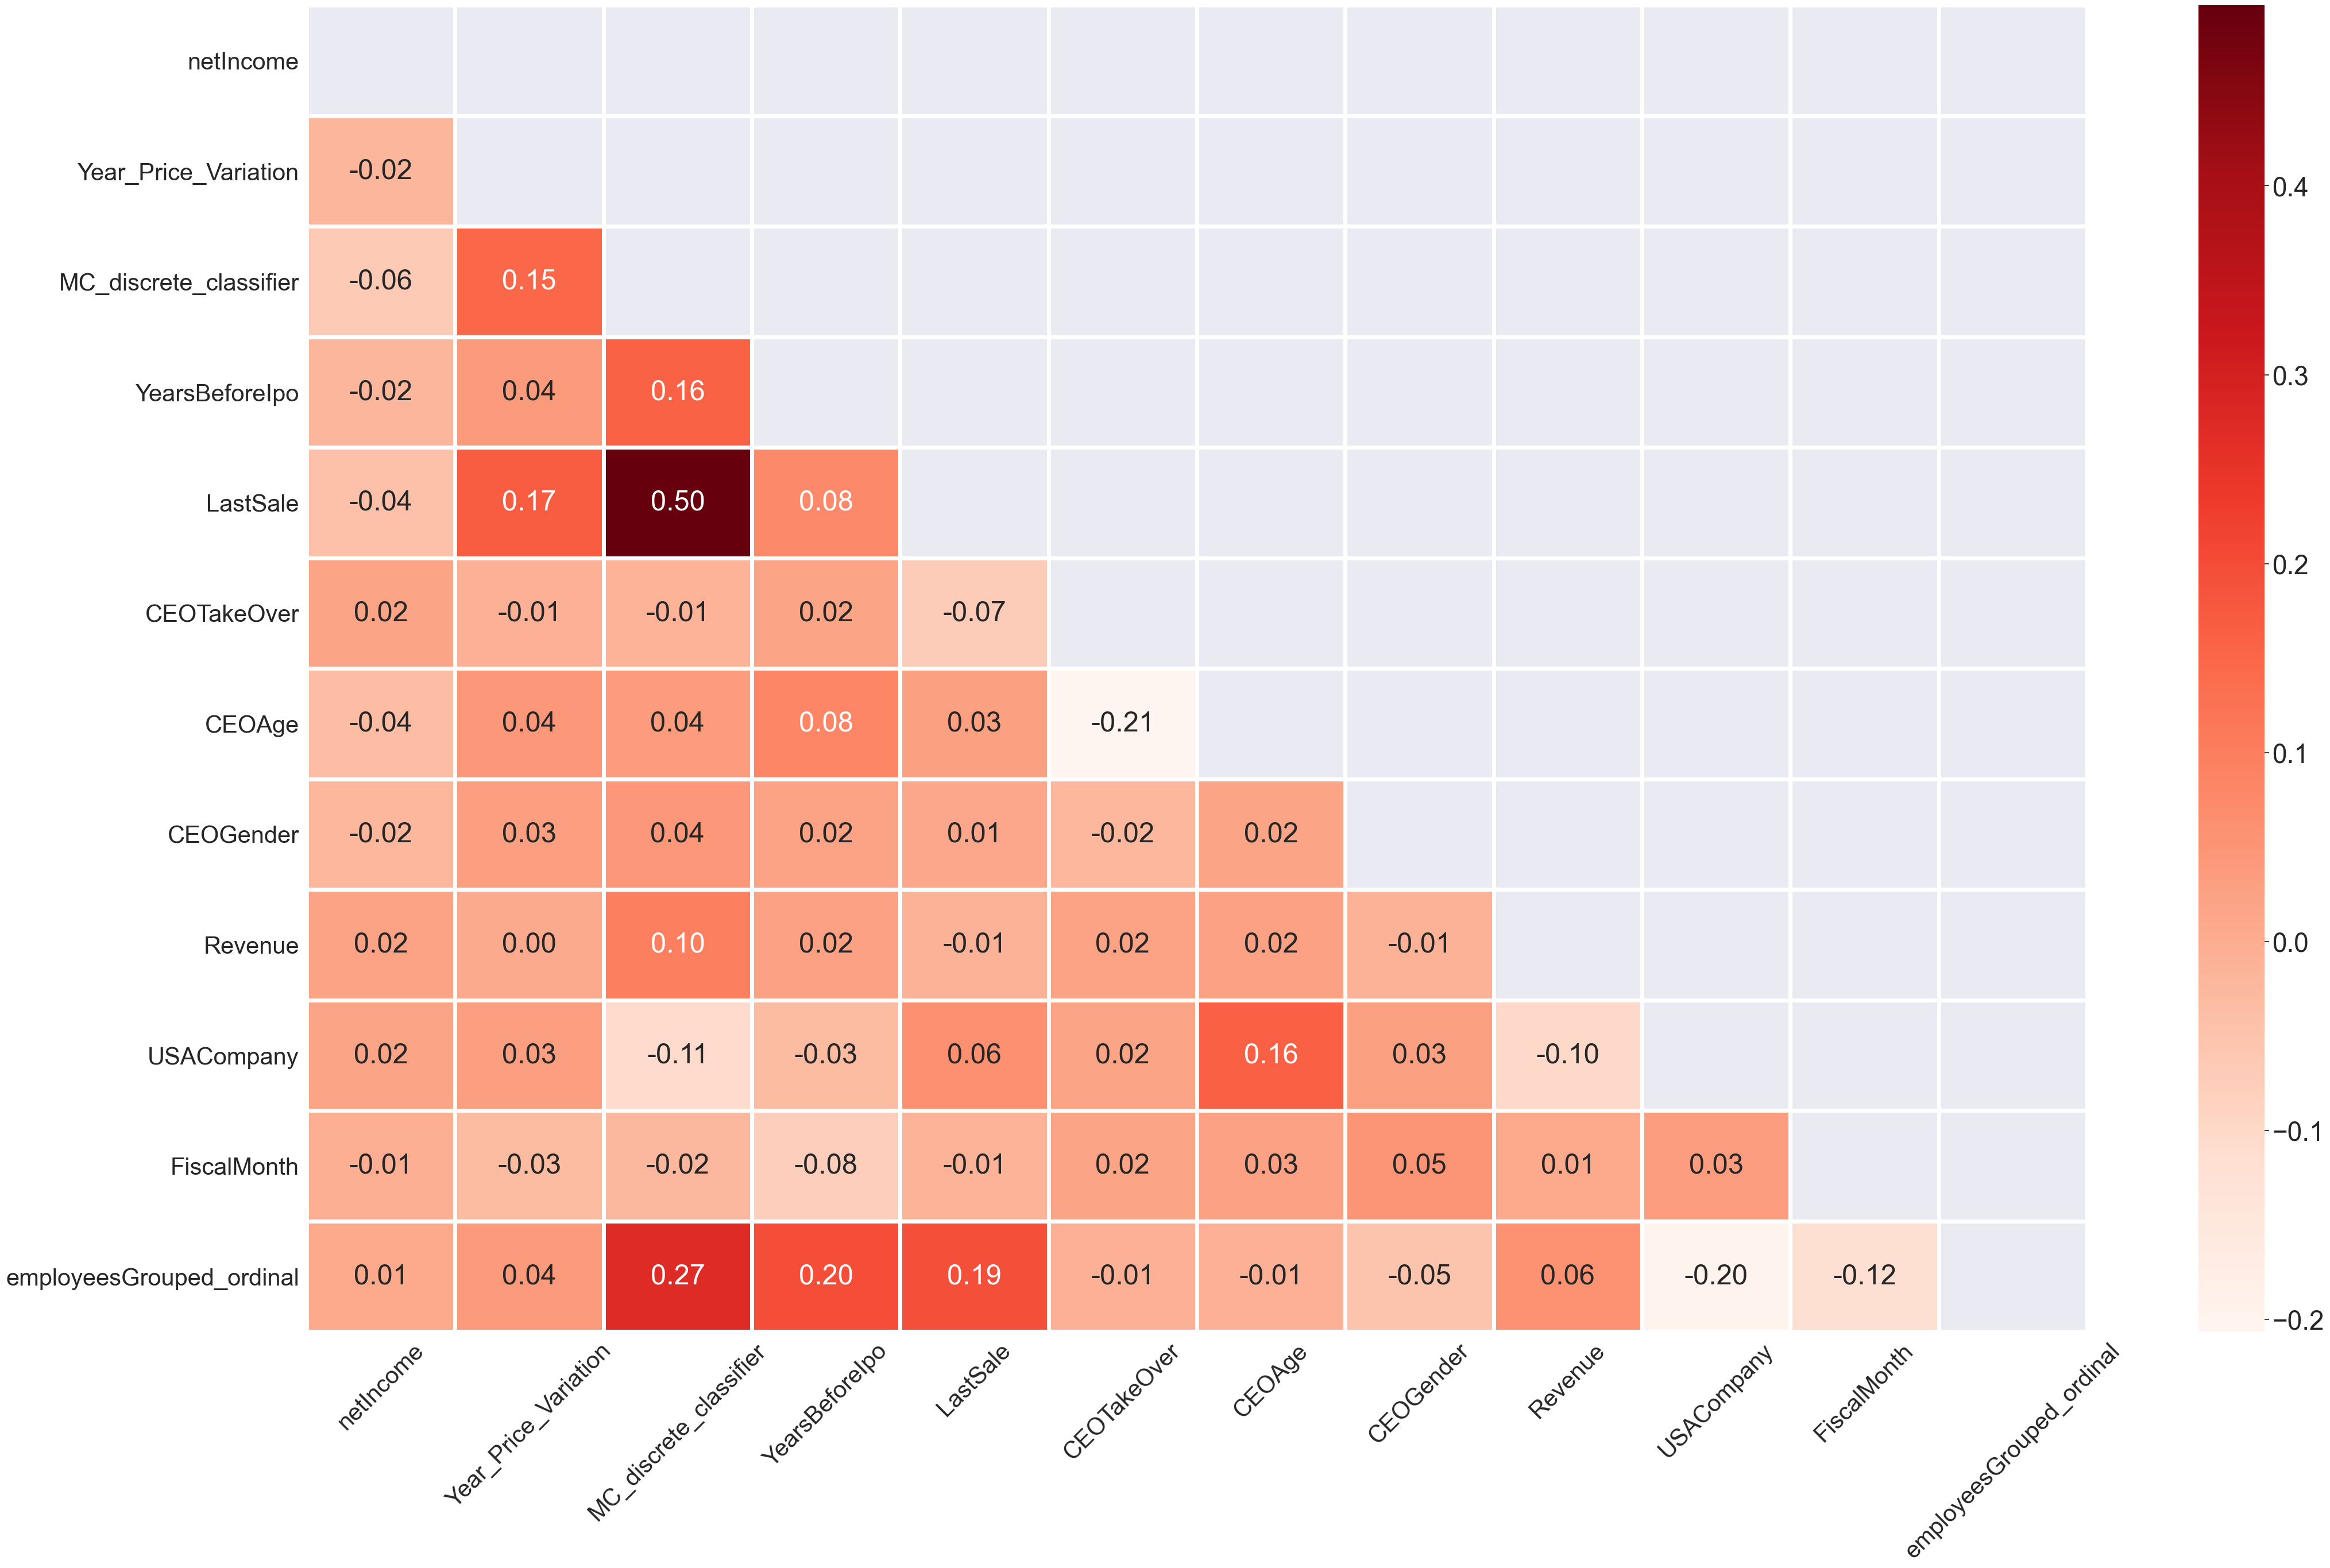

In [2141]:
fig, ax = plt.subplots(figsize=(50,30))

cor = df_main_clean4.corr()
mask = np.triu(np.ones_like(cor, dtype='bool'))

sns.set(font_scale=3)
g = sns.heatmap(cor,annot=True, annot_kws={'fontsize':35}, linewidths= 5, fmt=".2f", cmap = 'Reds', mask=mask)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 30, rotation = 45)

plt.show()

In [2142]:
df_main_clean4.to_csv('df_main_clean4.csv')

In [2143]:
# Variables a utilizar:

df_main_clean4.columns

Index(['Symbol', 'Sector', 'netIncome', 'Year_Price_Variation',
       'MC_discrete_classifier', 'employeesGrouped', 'YearsBeforeIpo',
       'LastSale', 'CEOTakeOver', 'CEOAge', 'CEOGender', 'Revenue',
       'USACompany', 'FiscalMonth', 'City', 'stateCountry', 'Industry',
       'employeesGrouped_ordinal'],
      dtype='object')

#### 7.2. El método de aprendizaje supervisado seleccionado es la regresión debido a que lo que se pretende es maximizar la inversión en compañías que recién salen a cotizar a bolsa luego de una IPO. En este sentido, se trata de predecir un resultado continuo como lo es el rendimiento en el primer año de cotización ('Year_Price_Variation').

# --------------------------------------------------------------------

#### 7.3. El método para evaluar la precisión del modelo será el R-Cuadrado ajustado y adicionalmente el RMSE - Root Mean Squared Error (Raíz del Error Cuadrático Medio). Dado que este no penaliza excesivamente los valores muy apartados de la prediccion del modelo.

#### 7.4. Expectativas del modelo:
- Poder predecir que tan rentable es participar en una IPO con al menos 2/3 (66.6%) de confianza en el modelo (en base al R2 Ajustado).
- El RMSE del training y test set deben ser similares (prevenir over y underfitting).
- Capacidad de condicionar al modelo en base a un sector o industria específico y tener un resultado igual de bueno al 66.6%.
- Un paso más avanzado sería armar un modelo que permita agrupar IPO's y brindar una predicción sobre un rango de rentabilidades. Por ejemplo, solicitarle al modelo armar un portafolio de 10 acciones que, como mínimo, cumpla con dos requisitos (al menos 8% de rentabilidad y 90% de probabilidad de conseguirlo).


# 8. Incorporar variables dummy

In [2144]:
# Encoding
df_Sector = pd.get_dummies(df_main_clean4['Sector'])

In [2145]:
df1 = df_main_clean4
df2 = pd.concat([df1, df_Sector], axis=1).reindex(df2.index)
df2.drop(['Sector', 'Industry', 'City', 'stateCountry'], axis=1, inplace=True)

In [2146]:
for i in df2.columns:
    print(f'{i}: {df2[i].isna().sum()}')

Symbol: 63
netIncome: 940
Year_Price_Variation: 63
MC_discrete_classifier: 63
employeesGrouped: 63
YearsBeforeIpo: 813
LastSale: 64
CEOTakeOver: 1079
CEOAge: 813
CEOGender: 883
Revenue: 1211
USACompany: 936
FiscalMonth: 953
employeesGrouped_ordinal: 63
Basic Industries: 63
Capital Goods: 63
Consumer Durables: 63
Consumer Non-Durables: 63
Consumer Services: 63
Energy: 63
Finance: 63
Health Care: 63
Miscellaneous: 63
No Specific Sector: 63
Public Utilities: 63
Technology: 63
Transportation: 63


# 9. Primeras Pruebas

In [2147]:
#Las empresas que no tienen datos de ventas las tomamos como si no hubiesen producido beneficios
df2['netIncome'] = df2['netIncome'].fillna(0)
df2['Revenue'] = df2['Revenue'].fillna(0)
df2['LastSale'] = df2['LastSale'].fillna(0)

In [2148]:
df2 = df2.dropna(axis=0)

In [2149]:
df3 = df2.drop(['Symbol','Year_Price_Variation', 'CEOTakeOver', 'CEOGender', 'CEOAge', 'employeesGrouped'], axis=1)

In [2150]:
# Borramos columnas con solo un valor para las filas
for i in df3.columns:
    if df3[i].nunique() == 1:
        df3.drop(f'{i}', axis=1, inplace=True)

In [2151]:
X = df3[df3.columns].values

y = df2['Year_Price_Variation']

In [2152]:
y.index = range(0, len(y))

In [2153]:
from sklearn.model_selection import train_test_split

## Normalizamos los datos

In [2154]:
from sklearn import preprocessing

In [2155]:
# Normalice features
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
    
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("The training data size is : {} ".format(x_train.shape))
print("The test data size is : {} ".format(x_test.shape))

The training data size is : (1506, 21) 
The test data size is : (503, 21) 


In [2156]:
np.set_printoptions(threshold=sys.maxsize)


Fin entrega parcial --------------------------------------------------------------------------------------------------------------------------------------------------------------

### Modelos de Regresion

In [2157]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error

In [2158]:
# Para poder usar el MAPE los valores verdaderos que sean 0 los convertimos a 1
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    y_true[y_true == 0] = 1

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2159]:
def relative_absolute_error(actual, predicted):
    numerator = np.sum(np.abs(predicted - actual))
    denominator = np.sum(np.abs(np.mean(actual) - actual))
    return numerator / denominator

In [2160]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=42)

#### 9.1. Ridge Regression

In [2161]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
reg_ridge = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=0.5))

#### 9.2. RidgeCV

In [2162]:
from sklearn.linear_model import RidgeCV
alphas = [1e-3, 1e-1, 1, 1e3, 1e6] #Cuanto ajuste queremos que haya (a menor alpha, mayor overfitting)
reg_ridgeCV = RidgeCV(alphas=1e-3, store_cv_values=True)
#cv_mse = np.mean(reg_ridgeCV.cv_values_, axis=0)

#### 9.3. Random Forest

In [2163]:
from sklearn.ensemble import RandomForestRegressor
reg_RF = RandomForestRegressor(n_estimators=10, random_state=42)

#### 9.4. XGBoost

In [2164]:
from xgboost import XGBRegressor
reg_XGB = XGBRegressor()

#### 9.5. SVM - Regression

In [2165]:
from sklearn.svm import SVR, SVC, NuSVC
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)

### Metricas de Regresion

In [2166]:
from sklearn.model_selection import cross_val_score, StratifiedGroupKFold, StratifiedKFold, LeaveOneOut, KFold
from sklearn.metrics import make_scorer, get_scorer_names

regressors_metrics = {'reg_ridge':'', 'reg_ridgeCV':'','reg_RF':'', 'reg_XGB':'','svr_rbf':''}
regressors = [reg_ridge, reg_ridgeCV, reg_RF, reg_XGB, svr_rbf]
cv_k_fold = KFold()

# LeaveOneOut demora multiples veces mas que un k-fold de 5 grupos
cv_loocv = LeaveOneOut()


In [2167]:
MAPEs = pd.DataFrame(['reg_ridge','reg_ridgeCV', 'reg_RF','reg_XGB', 'svr_rbf'], columns = ['Regresiones'])
MAPEs['Valores'] = np.nan

In [2168]:
 # Mediciones de Regresion

MAPE_score = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
RAE_score = make_scorer(relative_absolute_error, greater_is_better=False)


cont = 0
for i in regressors_metrics.keys():
    reg = regressors[cont]

# Multiplicamos por -1 porque los resultados por convencion salen  en negativo
    RMSE = cross_val_score(reg, X, y, cv=cv_k_fold, scoring='neg_root_mean_squared_error').mean()*-1
    MAE = cross_val_score(reg, X, y, cv=cv_k_fold, scoring='neg_mean_absolute_error').mean()*-1
    MAPE = cross_val_score(reg, X, y, cv=cv_k_fold, scoring=MAPE_score).mean()*-1
    RAE = cross_val_score(reg, X, y, cv=cv_k_fold, scoring=RAE_score).mean()*-1
    MedAE = cross_val_score(reg, X, y, cv=cv_k_fold, scoring='neg_median_absolute_error').mean()*-1


    regressors_metrics[i] =  pd.DataFrame({'Indicadores': ["RMSE", "MAE", "MAPE", "Relative_AE", "Median_AE"], 
    'Valores': [RMSE, MAE, MAPE, RAE, MedAE]})

    
    MAPEs['Valores'][cont] = MAPE

    cont += 1

In [2169]:
MAPEs

Regresiones     Valores
0    reg_ridge  210.518821
1  reg_ridgeCV  210.543050
2       reg_RF  297.242343
3      reg_XGB  296.474128
4      svr_rbf  206.821637

In [2170]:
# Ploteamos la mejor regresion segun el MAPE (svr_rbf)
# Primero debemos realizar las predicciones(y_pred)
svr_rbf.fit(train_X, train_y)
y_pred = svr_rbf.predict(test_X)

In [2171]:
plt.figure(figsize = (20,10))

plt.plot(y_pred, label='Prediccion')
plt.plot(y_test.values, label='Real')

plt.ylabel('Mpg')

plt.legend()
plt.show()

Ninguna regresión se ajusta bien al Dataset, incluso la mejor (SVR) tiene un error porcentual muy elevado (207%). Por este motivo se deberá testear con algoritmos de clasificación, para lo cual primero se crearán categorías.

El error se debe a que los valores reales son muy extremos (como se ve en la grafica) y varian mucho en cuanto a las variables predictoras.

## 10. Testing for Classification

### 10.1. Identificar el mejor punto de corte para un algoritmo de clasificación

Debido a que el objetivo de un inversión es maximizar el valor esperado, lo importante no es categorizar rendimientos, sino maximizarlo. Por ende lo importante no es medir el valor de precisión de cada categoría, sino hallar el punto de corte entre todas las categorías donde se maximice el valor esperado de una inversión.

Primero hay que hallar el mejor algoritmo de clasificación.

In [2172]:
from sklearn.multiclass import OneVsRestClassifier

In [2173]:
y_idx = y

In [2174]:
#y_multiclassifier = y
y_multiclassifier = pd.Series()

In [2175]:
for i in y:
    #print(i)
    if i > 0.25:
        #np.append(y_multiclassifier,4)
        y_multiclassifier = y_multiclassifier.append(pd.Series([4]))  
        #y_multiclassifier = y_multiclassifier.replace([i],4)  
    
    elif i >= 0.1 and i < 0.25:
        y_multiclassifier = y_multiclassifier.append(pd.Series([3]))  
        #y_multiclassifier = y_multiclassifier.replace([i],3)  

    elif i < 0.1 and i>=0:
        #np.append(y_multiclassifier,2)
        y_multiclassifier = y_multiclassifier.append(pd.Series([2]))  
        #y_multiclassifier = y_multiclassifier.replace([i],2)  

    elif i < 0 and i >= -0.4:
        #np.append(y_multiclassifier,1)
        y_multiclassifier = y_multiclassifier.append(pd.Series([1]))  
        #y_multiclassifier = y_multiclassifier.replace([i],1)  
  
    else:
        #np.append(y_multiclassifier,0)
        y_multiclassifier = y_multiclassifier.append(pd.Series([0])) 
        #y_multiclassifier = y_multiclassifier.replace([i],0)  
     

In [2176]:
train_X, test_X, train_y, test_y = train_test_split(X, y_multiclassifier, random_state=42)

### Confusion Matrix

In [2177]:
true_positive = []  #Se predice la clasificacion mas alta y le atina
bad_false_positive = [] #Se predice la clasificacion mas alta y en verdad es la mas baja (muy peligroso)

In [2178]:
from sklearn.metrics import confusion_matrix

clf_SVC = OneVsRestClassifier(SVC(probability=True))
clf_SVC.fit(train_X, train_y)

y_pred_multi_SVC = clf_SVC.predict(test_X)
confusion_matrix_multi = confusion_matrix(y_true=test_y, y_pred=y_pred_multi_SVC, labels=None, sample_weight=None, normalize=None)
true_positive.append(confusion_matrix_multi[0,0]/confusion_matrix_multi[:,0].sum())
bad_false_positive.append(confusion_matrix_multi[4,0]/confusion_matrix_multi[:,0].sum())

In [2179]:
confusion_matrix_multi

array([[15, 34,  8,  1, 33],
       [10, 41, 21,  5, 68],
       [ 4, 12, 24,  3, 21],
       [ 4, 16,  2,  3, 25],
       [14, 34,  8,  1, 96]], dtype=int64)

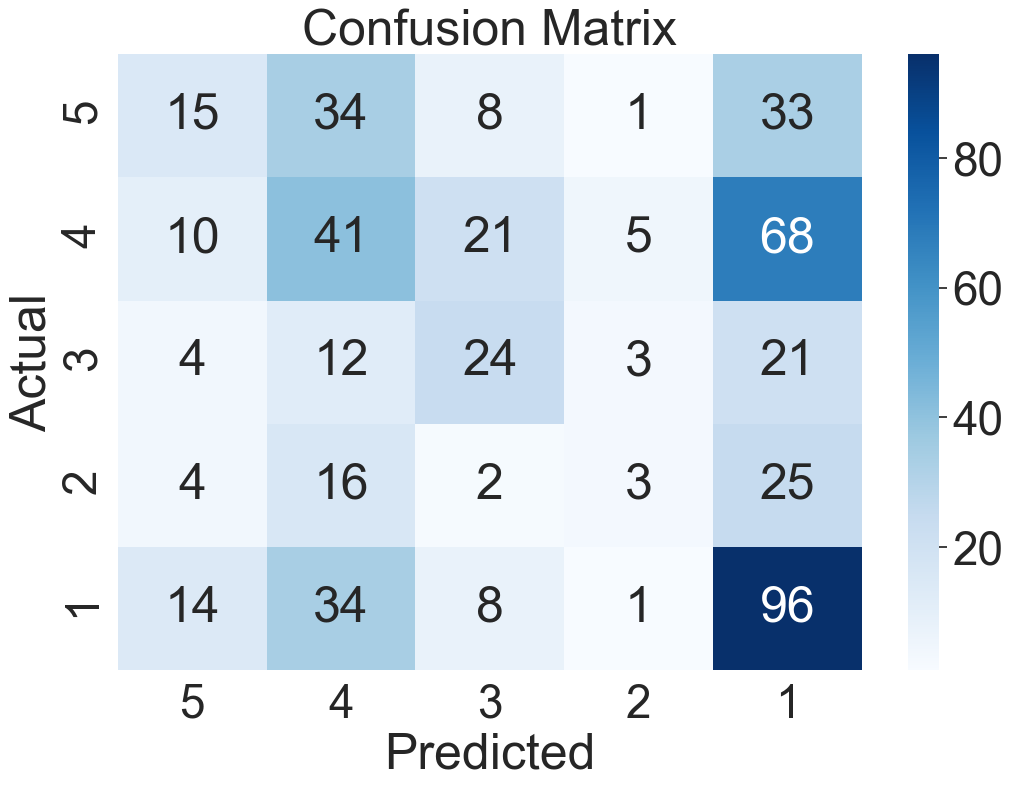

In [2180]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix_multi, annot=True, xticklabels=['5','4','3','2','1'], yticklabels=['5','4','3','2','1'], cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

plt.show()

In [2181]:
from sklearn.ensemble import RandomForestClassifier

In [2182]:
clf_RF = OneVsRestClassifier(RandomForestClassifier())
clf_RF.fit(train_X, train_y)
y_pred_multi_RF = clf_RF.predict(test_X)

In [2183]:
confusion_matrix_multi = confusion_matrix(y_true=test_y, y_pred=y_pred_multi_RF, labels=None, sample_weight=None, normalize=None)
true_positive.append(confusion_matrix_multi[0,0]/confusion_matrix_multi[:,0].sum())
bad_false_positive.append(confusion_matrix_multi[4,0]/confusion_matrix_multi[:,0].sum())

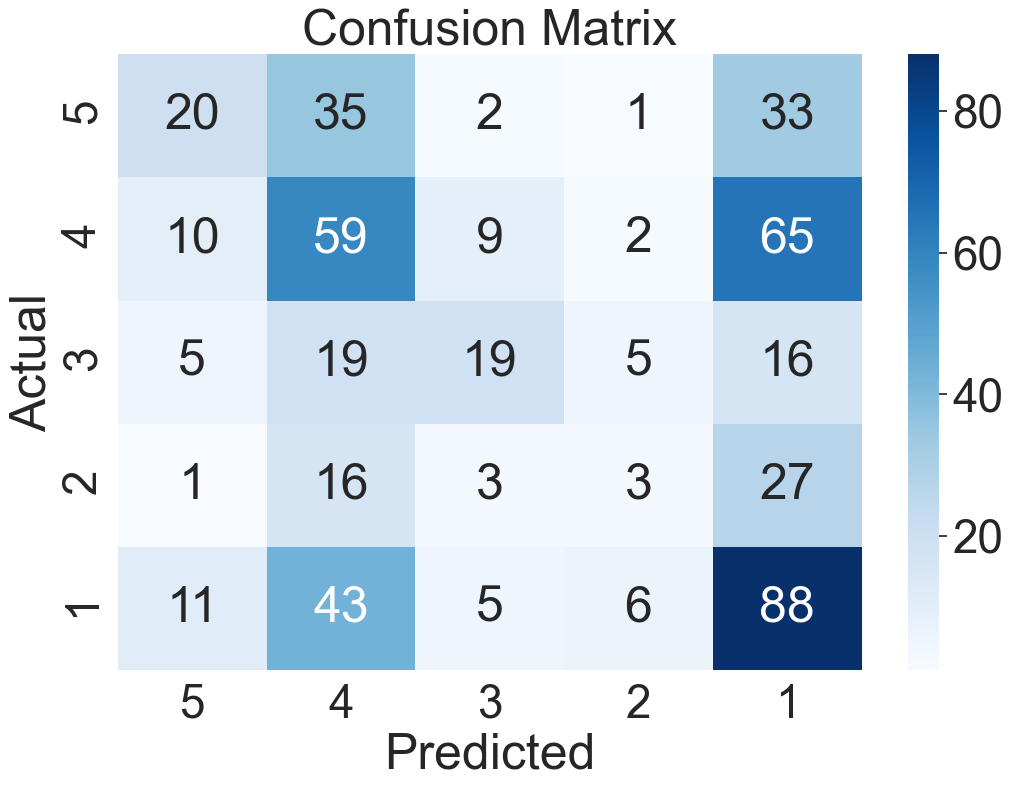

In [2184]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix_multi, annot=True, xticklabels=['5','4','3','2','1'], yticklabels=['5','4','3','2','1'], cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

plt.show()

In [2185]:
from xgboost import XGBClassifier

In [2186]:
clf_XGB = OneVsRestClassifier(XGBClassifier())
clf_XGB.fit(train_X, train_y)
y_pred_multi_XGB = clf_XGB.predict(test_X)

In [2187]:
confusion_matrix_multi = confusion_matrix(y_true=test_y, y_pred=y_pred_multi_XGB, labels=None, sample_weight=None, normalize=None)
true_positive.append(confusion_matrix_multi[0,0]/confusion_matrix_multi[:,0].sum())
bad_false_positive.append(confusion_matrix_multi[4,0]/confusion_matrix_multi[:,0].sum())

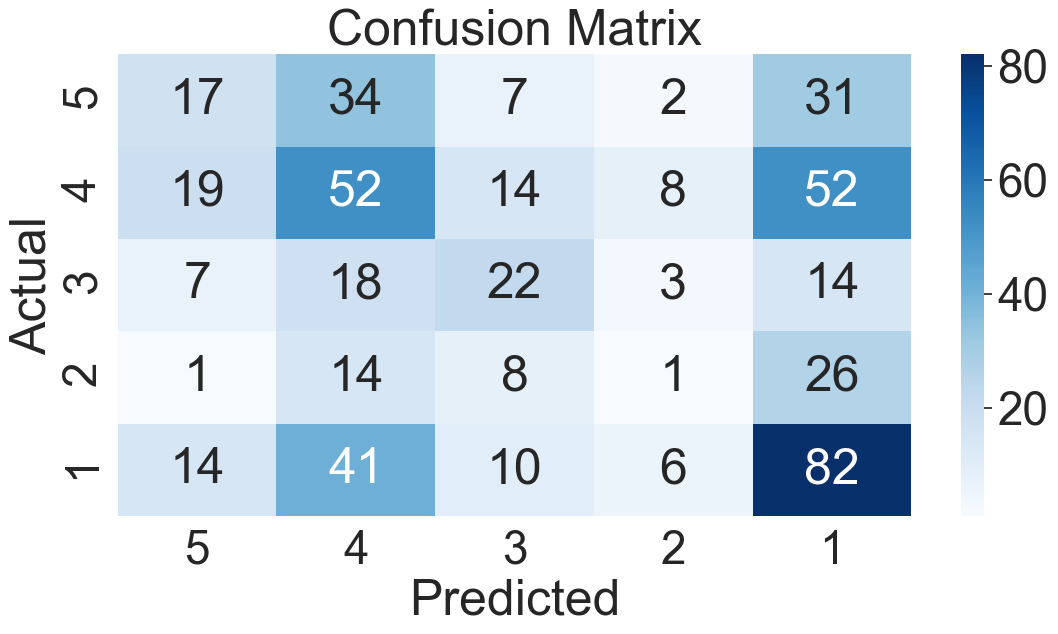

In [2188]:
plt.figure(figsize=(12.8,6))
sns.heatmap(confusion_matrix_multi, annot=True, xticklabels=['5','4','3','2','1'], yticklabels=['5','4','3','2','1'], cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

plt.show()

In [2189]:
classificator_metrics = {'clf_SVC':'', 'clf_RF':'','clf_XGB':''}
classifiers = [clf_SVC, clf_RF, clf_XGB]
cv_S_k_fold = StratifiedKFold()

# LeaveOneOut demora multiples veces mas que un k-fold de 5 grupos
cv_loocv = LeaveOneOut()

In [2190]:
ROC_AUCs = pd.DataFrame(['clf_SVC', 'clf_RF','clf_XGB'], columns = ['Clasificadores'])
ROC_AUCs['Valores'] = np.nan

In [2191]:
# Mediciones de Clasificacion
# Macro-averaged: all classes equally contribute to the final averaged metric

cont = 0
for i in classificator_metrics.keys():
    clf = classifiers[cont]

    # Multiplicamos por -1 porque los resultados por convencion salen  en negativo
    accuracy = cross_val_score(clf, X, y_multiclassifier, cv=cv_S_k_fold, scoring='accuracy').mean()
    precision = cross_val_score(clf, X, y_multiclassifier, cv=cv_S_k_fold, scoring='precision_macro').mean()
    recall = cross_val_score(clf, X, y_multiclassifier, cv=cv_S_k_fold, scoring='recall_macro').mean()
    roc_auc = cross_val_score(clf, X, y_multiclassifier, cv=cv_S_k_fold, scoring='roc_auc_ovr').mean()


    classificator_metrics[i] =  pd.DataFrame({'Indicadores': ["Accuracy", "Precision", "Recall","ROC_AUC"], 
    'Valores': [accuracy, precision, recall, roc_auc]})

    
    ROC_AUCs['Valores'][cont] = roc_auc

    cont += 1

In [2192]:
classificator_metrics

{'clf_SVC':   Indicadores   Valores
 0    Accuracy  0.354896
 1   Precision  0.292357
 2      Recall  0.293877
 3     ROC_AUC  0.586144,
 'clf_RF':   Indicadores   Valores
 0    Accuracy  0.396207
 1   Precision  0.362486
 2      Recall  0.335146
 3     ROC_AUC  0.646274,
 'clf_XGB':   Indicadores   Valores
 0    Accuracy  0.356883
 1   Precision  0.323722
 2      Recall  0.307994
 3     ROC_AUC  0.628769}

In [2193]:
ROC_AUCs

Clasificadores   Valores
0        clf_SVC  0.586144
1         clf_RF  0.646274
2        clf_XGB  0.628769

##### Realizamos una tabla y una grafica comparativa entre modelos, comparando los aciertos y los peores desaciertos


In [2194]:
df = pd.DataFrame(true_positive)
df['True Positive Rate'] = true_positive
df.drop(0,axis=1, inplace=True)

In [2195]:
df['Bad False Positive'] = bad_false_positive

In [2196]:
df['Classifier'] = ['SVC','RandomForest','XGBoost']
df.set_index('Classifier', inplace=True)

In [2197]:
df = df.reset_index(level=0)
df.drop(df.columns[2], inplace=True, axis=1)
df.rename(columns={'True Positive Rate':'Rate'}, inplace=True)
df['Type_of_Rate'] = 'True Positive Rate'

In [2198]:
df1 = pd.DataFrame(bad_false_positive)
df1['Rate'] = bad_false_positive
df1.drop(0,axis=1, inplace=True)
df1['Classifier'] = ['SVC','RandomForest','XGBoost']
df1['Type_of_Rate'] = '"Bad" False Positive Rate'


In [2199]:
df2 = pd.concat([df,df1], axis=0)

<function matplotlib.pyplot.show(close=None, block=None)>

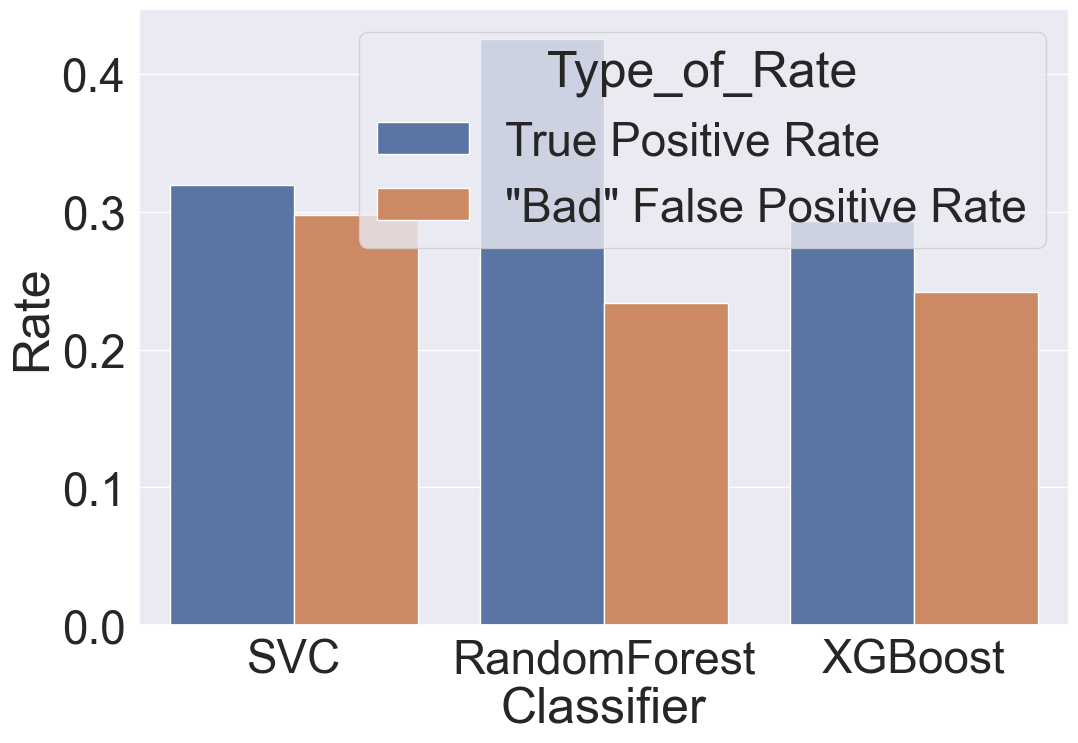

In [2200]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=df2, x=df2['Classifier'], y='Rate', hue='Type_of_Rate')
plt.show

El Mejor modelo es el SVC, por lo que será graficado en la curva ROC Multiple y será el utilizado en la clasificación binaria.

### ROC Curve Multiple - Random Forest (Mejor Modelo)

In [2201]:
n_classes = len(np.unique(y_multiclassifier))

y_score = clf_RF.predict_proba(test_X)

In [2202]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(train_y)
y_onehot_test = label_binarizer.transform(test_y)
y_onehot_test.shape  # (n_samples, n_classes)

(503, 5)

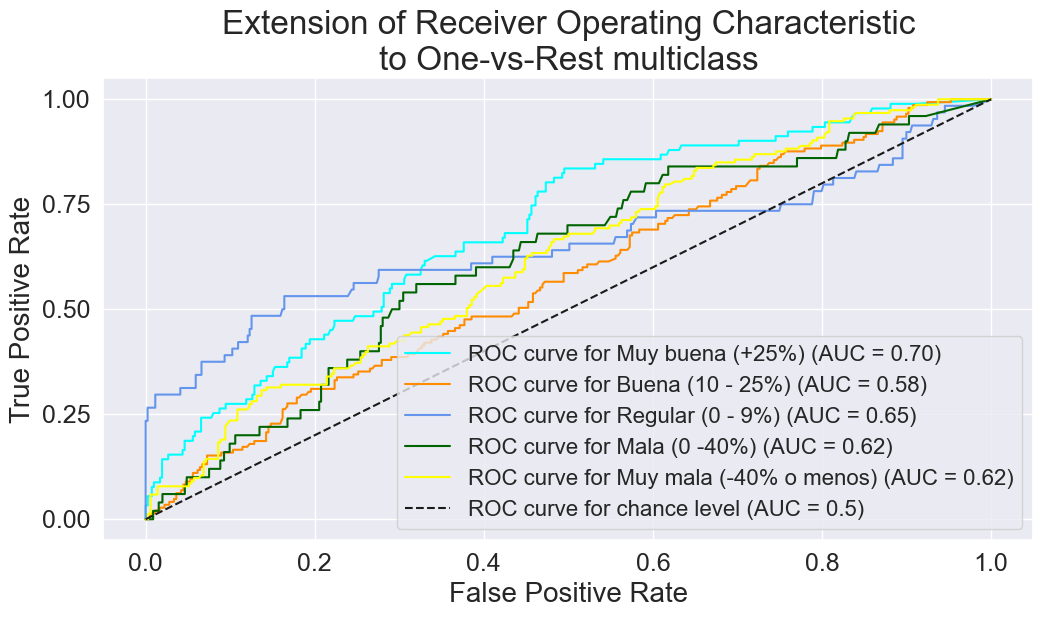

In [2203]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

fig, ax = plt.subplots(figsize=(12, 6))

target_names = ['Muy buena (+25%)', 'Buena (10 - 25%)', 'Regular (0 - 9%)', 'Mala (0 -40%)', 'Muy mala (-40% o menos)']
class_id = [5,4,3,2,1]

colors = cycle(["aqua", "darkorange", "cornflowerblue", 'darkgreen', 'yellow'])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass", fontsize=24, loc='center')
plt.legend(fontsize=16)
plt.show()

### Feature Importance for Multiple Classifier

In [2204]:
from eli5.sklearn import PermutationImportance

html_obj = PermutationImportance(clf_RF, random_state=42).fit(test_X, test_y)

df_fi = pd.DataFrame(dict(feature_names=df3.columns.tolist(),
                          feat_imp=html_obj.feature_importances_, 
                          std=html_obj.feature_importances_std_,
                          ))
df_fi = df_fi.round(3)
df_fi.sort_values('feat_imp', ascending=False)

feature_names  feat_imp    std
3                   LastSale     0.033  0.009
0                  netIncome     0.021  0.012
19                Technology     0.009  0.005
18          Public Utilities     0.008  0.003
12         Consumer Services     0.007  0.009
13                    Energy     0.006  0.002
1     MC_discrete_classifier     0.005  0.007
6                FiscalMonth     0.003  0.005
17        No Specific Sector     0.002  0.003
16             Miscellaneous     0.002  0.001
4                    Revenue     0.001  0.015
9              Capital Goods     0.001  0.003
15               Health Care    -0.000  0.003
20            Transportation     0.000  0.001
11     Consumer Non-Durables     0.000  0.002
2             YearsBeforeIpo    -0.003  0.004
10         Consumer Durables    -0.004  0.003
8           Basic Industries    -0.006  0.001
5                 USACompany    -0.006  0.005
14                   Finance    -0.009  0.005
7   employeesGrouped_ordinal    -0.010  0.014

### 10.1.2. Random Forest - Classifier (binario)

La clasificacion binaria (simple) puede traer el peligro de que se considera igual una compañía que crece 9% a una que quiebra (-100%). Por lo que trazaremos los valores promedio de los True Positives y los False Positives para determinar si el valor esperado es rentable.

In [2205]:
# Lista con valor original y tres puntos de corte para la clasificacion binaria (0%, 10% y 25%)
# Deben estar ordenados en el mismo orden que el diccionario de los 'for' a continuacion (de 0% a 25%)
y_classificator = [[i] for i in y.to_list()]
for i in range(0, len(y)):
    if y[i] > 0:
        y_classificator[i].append(1)
    else:
        y_classificator[i].append(0)
    
    if y[i] > 0.1:
        y_classificator[i].append(1)
    else:
        y_classificator[i].append(0)

    if y[i] > 0.25:
        y_classificator[i].append(1)
    else:
        y_classificator[i].append(0)


In [2206]:
train_X, test_X, train_y_binario, test_y_binario = train_test_split(X, y_classificator, random_state=42)


In [2207]:
test_a = [i[0] for i in test_y_binario]

cortes = ['Corte en 0%', 'Corte en 10%', 'Corte en 25%']

resultados_de_cada_corte = {}

cont = 0
# Debe recorrer del segundo hasta el 4 espacio de cada lista
for j in range(1,4):

    train_b = [i[j] for i in train_y_binario]
    test_b = [i[j] for i in test_y_binario]
    #clf_RF_binaria_binaria = NuSVC(gamma="auto", probability=True)'    

    clf_RF_binaria = RandomForestClassifier()
    clf_RF_binaria.fit(train_X, train_b)
    y_pred_binario = clf_RF_binaria.predict(test_X)
    
    y_results=pd.DataFrame()
    y_results = pd.DataFrame(test_a, columns=['test_y_continuo'])
    y_results['test_y_binario'] = test_b
    y_results['pred_y_binario'] = y_pred_binario

    results = pd.DataFrame()
    results['test_y_continuo'] = y_results['test_y_continuo']
    results['test_y_binario'] = y_results['test_y_binario']
    results['pred_y_binario'] = y_results['pred_y_binario']
    resultados_de_cada_corte[f'{cortes[cont]}'] = results

    cont += 1

In [2208]:
TP = {}
FP = {}

cortes = ['Corte en 0%', 'Corte en 10%', 'Corte en 25%']

cont = 0
for i in range(0, len(y_test)):
    for j in range(0,3):
        if resultados_de_cada_corte[cortes[j]].pred_y_binario[i] == 1:
            if resultados_de_cada_corte[cortes[j]].test_y_binario[i] == resultados_de_cada_corte[cortes[j]].pred_y_binario[i]:
                #TP[f'{cortes[j]}'].append(resultados_de_cada_corte[cortes[j]].test_y_continuo[i])
                TP.setdefault(f'{cortes[j]}', []).append(resultados_de_cada_corte[cortes[j]]['test_y_continuo'][i])
            elif resultados_de_cada_corte[cortes[j]].test_y_binario[i] != resultados_de_cada_corte[cortes[j]].pred_y_binario[i]:
                #FP[f'{cortes[cont]}'].append(resultados_de_cada_corte[cortes[cont]].test_y_continuo[i])
                FP.setdefault(f'{cortes[j]}', []).append(resultados_de_cada_corte[cortes[j]]['test_y_continuo'][i])


In [2209]:
corte = [0,0.1,0.25]
TPFP_score = pd.DataFrame(cortes, columns=['Punto de Corte'])
TPFP_score['TP Mean'] = np.NAN
TPFP_score['FP Mean'] = np.NAN
TPFP_score['Precision'] = np.NAN
TPFP_score['Score'] = np.NAN
TPFP_score['corte'] = [0,0.1,0.25]
TPFP_score.set_index('corte', inplace=True)

In [2210]:
for i in range(0,len(cortes)):
    TPFP_score.iloc[i,1] = np.mean(TP[cortes[i]])
    TPFP_score.iloc[i,2] = np.mean(FP[cortes[i]])
    TPFP_score.iloc[i,3] = len(TP[cortes[i]])/(len(TP[cortes[i]])+len(FP[cortes[i]]))

    # Calculamos el Score como: (TP Mean * Precision) + (FP Mean * (1-Precision))
    TPFP_score.iloc[i,4] = (TPFP_score.iloc[i,1]*TPFP_score.iloc[i,3])+(TPFP_score.iloc[i,2]*(1-TPFP_score.iloc[i,3]))



In [2229]:
TPFP_score

Punto de Corte   TP Mean   FP Mean  Precision     Score
corte                                                        
0.00     Corte en 0%  0.450305 -0.299134   0.592476  0.144891
0.10    Corte en 10%  0.564126 -0.244840   0.543478  0.194815
0.25    Corte en 25%  0.708302 -0.107063   0.432432  0.245527

**Score: es el rendimiento promedio de un portafolio que contiene todas las entradas de prueba (test_X).**

In [2230]:
corte_mejor = TPFP_score[TPFP_score['Score'] == TPFP_score['Score'].max()].index.values

In [2231]:
# Rehacemos la variable binaria 'y' con el mejor punto de corte
y_classificator = []
for i in range(0, len(y)):
    if y[i] > corte_mejor:
        y_classificator.append(1)
    else:
        y_classificator.append(0)


In [2232]:
train_X, test_X, train_y_binario, test_y_binario = train_test_split(X, y_classificator, random_state=42)

In [2233]:
#clf_RF_binaria_binaria = NuSVC(gamma="auto", probability=True)
clf_RF_binaria = RandomForestClassifier()
clf_RF_binaria.fit(train_X, train_y_binario)
y_pred_binario = clf_RF_binaria.predict(test_X)

In [2234]:
# Accuracy and False Positive Rate
from sklearn.metrics import accuracy_score
accuracy = cross_val_score(estimator=clf_RF_binaria, X=train_X, y=train_y_binario, cv=cv_S_k_fold, scoring='accuracy').mean()
FPR = 1-cross_val_score(estimator=clf_RF_binaria, X=train_X, y=train_y_binario, cv=cv_S_k_fold, scoring='precision').mean()
print("Accuracy: {:.1f} %".format(accuracy*100))
print("False Positive Ratio: {:.1f} %".format(FPR*100))

Accuracy: 67.7 %
False Positive Ratio: 57.2 %


In [2235]:
confusion_matrix_binaria = confusion_matrix(y_true=test_y_binario, y_pred=y_pred_binario, labels=None, sample_weight=None, normalize=None)
confusion_matrix_binaria

array([[313,  37],
       [124,  29]], dtype=int64)

El modelo predice poco más de la mitad (52%) de las veces acertadamente si una acción incrementará su valor más de un 10%.

Si el modelo predice que será positivo, hay 48% de posibilidades que se trate de un falso positivo, este error (tipo 1, falso positivo) es más riesgoso que el tipo 2 (falso negativo) para este tipo de inversión, ya que una mala inversión puede equivaler a entre 9 y 10 veces buenas inversiones (debido a que puede ser entre -100% y + 9 %).

**El modelo es bueno porque otorga un rendimiento promedio de 18.6% anual. Esto es muy superior al retorno de ETF de mediano/gran rendimiento como el del S&P500 (9%).**

### ROC Curve - RF (binario)

AUC for our classifier is: 0.6219327731092436


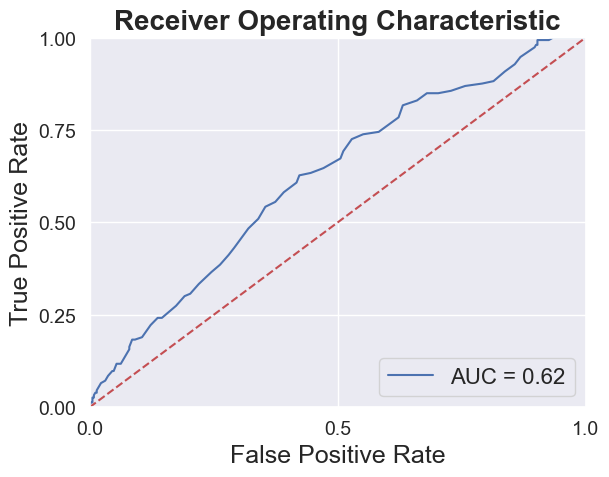

In [2236]:
# Clasificacion Binaria
from sklearn.metrics import roc_curve, auc

class_probabilities = clf_RF_binaria.predict_proba(test_X)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(test_y_binario, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic', fontsize=20, fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=16, loc='lower right')
plt.show()

### Feature Importance for Binary Classifier

In [2237]:
from eli5.sklearn import PermutationImportance

html_obj = PermutationImportance(clf_RF_binaria, random_state=42).fit(test_X, test_y_binario)

df_fi = pd.DataFrame(dict(feature_names=df3.columns.tolist(),
                          feat_imp=html_obj.feature_importances_, 
                          std=html_obj.feature_importances_std_,
                          ))
df_fi = df_fi.round(3)
df_fi.sort_values('feat_imp', ascending=False)

feature_names  feat_imp    std
3                   LastSale     0.029  0.010
14                   Finance     0.004  0.004
16             Miscellaneous     0.003  0.002
0                  netIncome     0.002  0.010
18          Public Utilities     0.002  0.003
5                 USACompany     0.001  0.004
13                    Energy     0.001  0.004
11     Consumer Non-Durables     0.000  0.002
17        No Specific Sector    -0.000  0.002
20            Transportation     0.000  0.001
8           Basic Industries     0.000  0.001
1     MC_discrete_classifier    -0.002  0.009
12         Consumer Services    -0.002  0.001
6                FiscalMonth    -0.003  0.004
9              Capital Goods    -0.004  0.001
19                Technology    -0.004  0.003
10         Consumer Durables    -0.004  0.001
4                    Revenue    -0.006  0.005
2             YearsBeforeIpo    -0.006  0.010
7   employeesGrouped_ordinal    -0.008  0.009
15               Health Care    -0.012  0.002

Las dos variables más importantes son LastSale y NetIncome.
Es curioso porque estas no son relativas a la capitalización de mercado de la compañía, sino que son valores absolutos. Es decir, parece favorecer empresas con mayor capitalización de mercado. Recordemos que según el cuadro de correlaciones, LastSale tiene una correlación de 0.5 (media) con MC_discrete_classifier, pero no tiene ninguna correlación con NetIncome.

## Principal Component Analysis (PCA)

In [2238]:
from sklearn.decomposition import PCA

In [2245]:
pca=PCA(n_components=10)
pca.fit(X)

PCA(n_components=10)

In [2246]:
transformada = pca.transform(X.data)
print(X.data.shape)
print(transformada.shape)

(2009, 21)
(2009, 10)


In [2247]:
train_X, test_X, train_y_binario, test_y_binario = train_test_split(transformada, y_classificator, random_state=42)

In [2248]:
clf_RF_binaria = RandomForestClassifier()
clf_RF_binaria.fit(train_X, train_y_binario)

RandomForestClassifier()

In [2249]:

# Clasificacion Binaria
from sklearn.metrics import roc_curve, auc

class_probabilities = clf_RF_binaria.predict_proba(test_X)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(test_y_binario, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic', fontsize=20, fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=16, loc='lower right')
plt.show()

AUC for our classifier is: 0.5714285714285714


In [2255]:
pd.DataFrame(pca.components_, columns=df3.columns)

netIncome  MC_discrete_classifier  YearsBeforeIpo  LastSale   Revenue  \
0  -0.001908                0.237068        0.061968  0.025870  0.003374   
1   0.004844                0.009725        0.011004  0.004818  0.001821   
2  -0.006226                0.173479        0.018719  0.018913  0.001907   
3  -0.001476                0.208528        0.060283  0.012693  0.003242   
4  -0.001197               -0.214377       -0.075004 -0.042271  0.002299   
5   0.003153               -0.199451       -0.022012 -0.037555  0.001962   
6   0.010364               -0.279968        0.048043 -0.023282 -0.006452   
7   0.001711               -0.103351       -0.003291 -0.023268  0.001667   
8   0.000483                0.040956        0.043703  0.001831  0.005666   
9  -0.005697               -0.118232        0.047518 -0.020858 -0.000469   

   USACompany  FiscalMonth  employeesGrouped_ordinal  Basic Industries  \
0   -0.120494    -0.116676                  0.566761          0.027228   
1   -0.135293     0.042092                  0.016984          0.009167   
2   -0.395356    -0.069552                  0.255014          0.051097   
3   -0.485214     0.105981                  0.342112          0.036736   
4   -0.733896     0.024321                 -0.408868         -0.055342   
5   -0.127983     0.176760                 -0.235576          0.181538   
6   -0.104709    -0.506033                  0.016362          0.065836   
7    0.009412    -0.592806                  0.072414          0.067695   
8   -0.036159    -0.470218                 -0.116413         -0.478326   
9    0.028314    -0.188849                 -0.065774          0.728306   

   Capital Goods  Consumer Durables  Consumer Non-Durables  Consumer Services  \
0       0.040386           0.010529               0.029519           0.406029   
1       0.006472           0.000464               0.003374          -0.530438   
2       0.058550           0.010572               0.036051          -0.540374   
3       0.026964          -0.001120               0.022597           0.026159   
4      -0.192532          -0.046330              -0.073771           0.342629   
5       0.237407           0.034609               0.048675          -0.214809   
6       0.422317           0.016059               0.077611          -0.056301   
7      -0.660625           0.028133               0.131348          -0.077455   
8       0.411037          -0.024275               0.010363           0.031003   
9       0.025623          -0.000839               0.014112          -0.003574   

     Energy   Finance  Health Care  Miscellaneous  No Specific Sector  \
0  0.015133 -0.028876    -0.639034       0.022937           -0.028017   
1  0.011550  0.767995    -0.325987       0.003590           -0.001372   
2  0.055605 -0.413344     0.146020       0.032529           -0.015273   
3  0.026052  0.108855     0.384085       0.015768           -0.086224   
4 -0.050083  0.072755    -0.092501      -0.070751           -0.031399   
5  0.381489 -0.352900    -0.443962       0.075016            0.281716   
6 -0.623079 -0.023601    -0.018771       0.033943            0.225674   
7  0.247133 -0.001424     0.025473       0.080251            0.284456   
8  0.493434  0.057762     0.042035      -0.042615           -0.289013   
9  0.084667 -0.002133    -0.021066      -0.023777           -0.615561   

   Public Utilities  Technology  Transportation  
0          0.032974    0.098627        0.012565  
1          0.008279    0.038741        0.008166  
2          0.051429    0.493116        0.034022  
3          0.047869   -0.643747        0.036005  
4         -0.060481    0.218068        0.039738  
5          0.098007   -0.388111        0.061325  
6         -0.017037   -0.130076        0.027425  
7          0.001469   -0.133511        0.007059  
8         -0.160583   -0.023975       -0.026847  
9         -0.153546   -0.018472       -0.013739

In [2256]:
from eli5.sklearn import PermutationImportance

html_obj = PermutationImportance(clf_RF_binaria, random_state=42).fit(test_X, test_y_binario)

df_fi = pd.DataFrame(dict(feat_imp=html_obj.feature_importances_, 
                          std=html_obj.feature_importances_std_,
                          ))
df_fi = df_fi.round(3)
df_fi.sort_values('feat_imp', ascending=False)

feat_imp    std
9    -0.007  0.008
0    -0.008  0.005
8    -0.010  0.004
7    -0.014  0.008
5    -0.017  0.003
6    -0.017  0.007
1    -0.021  0.003
3    -0.023  0.006
2    -0.029  0.010
4    -0.029  0.012

# --------------------------------------------------------------------------------------------

#### 10.2. Identificar un mix de compañías que logren un 10% de rentabilidad (maximizar la probabilidad de que esto suceda)